In [79]:
library(mirt)
library(psych)
library(stringr)
library(readxl)
library(jsonlite)
library(tidyverse)
library(knitr)
library(magrittr)
library(dplyr)
library(ggplot2)
library(ggExtra)
library(latticeExtra)
library(repr)
#library(GDINA)

`%nin%` = Negate(`%in%`)

my_summary <- function(x) {
  tibble(n = sum(!is.na(x)),
    min = min(x,na.rm = T),
         q1 = quantile(x, 0.25),
         avg = mean(x, na.rm =T),
         med = median(x, na.rm = T),
         q3 = quantile(x, 0.75),
         max = max(x, na.rm = T)
  )
}

my_summary2 <- function(x) {
  tibble(
         avg = mean(x, na.rm =T),
         sd = sd(x, na.rm = T)
  )
}

# DATA CLEANING FUNCTIONS

clean_responses <- function( a_df ) {
  new_df <- a_df %>%
    select(candidate_id, try_count, created_at, quizz_question_id, is_correct, time_to_answer) %>%
  mutate(created_at = as.POSIXct(str_replace(created_at, "T", " "), format = "%Y-%m-%d %H:%M")) %>%
  filter(candidate_id > 80) %>%
  mutate(
    is_correct = as.numeric(is_correct),
    quizz_question_id = as.character(quizz_question_id)
  )
  return( new_df )
}

create_wide_response <- function( a_df ) {
  new_df <- a_df %>%
  select(-created_at, -time_to_answer) %>%
  distinct(candidate_id, try_count, quizz_question_id, .keep_all = TRUE) %>%
  pivot_wider(id_cols = c(candidate_id, try_count),
              names_from = quizz_question_id,
              values_from = is_correct)
  return(new_df)
}



# Calibration, Scoring, & Impact Analyses

In [80]:

setwd('/Users/larrythomas/workspace/larry/Language_Assessment/')
py_responses <- fromJSON('data/py_responses.json', flatten = TRUE)
py_qs <- fromJSON('data/py_ques_meta.json', flatten = TRUE)
py_quiz <- fromJSON('data/py_quiz_scores.json', flatten = TRUE)

In [81]:

# RESPONSES

py_resp <- clean_responses(py_responses)
py_resp_wide <- create_wide_response(py_resp) 


# QUESTIONS
questions <- colnames(py_resp_wide)[-c(1:2)]

df_blueprint <- py_qs %>%
  select(id, time_to_complete, metadata.Claim, metadata.Label, `metadata.Content Target`) %>%
  slice(match(questions, id)) %>%
  rename(question_id = id, claim = metadata.Claim, name = metadata.Label, target = `metadata.Content Target`) %>%
  mutate(
    claim = str_trim(claim, side = "both")
  )

#### Number of Questions Attempted

In [82]:

tbl_test_completed_time <- py_resp %>%
  mutate(
    time_to_answer = if_else(time_to_answer > 400, 400L, time_to_answer)
  ) %>%
  group_by(candidate_id, try_count) %>%
  summarise(
    Qs = n(),
    Test_Min = round(sum(time_to_answer, na.rm = T)/60, 2)
    ) 

candidates_completed <- tbl_test_completed_time$candidate_id[which(
  (tbl_test_completed_time$Qs == 30) & (tbl_test_completed_time$Test_Min > 15))]
mask_analytic_sample <- which(py_resp_wide$candidate_id %in% candidates_completed )

table(tbl_test_completed_time$Qs, useNA = "always")


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   18 
  12    5   11    4    3    3    3    3    1    2    4    2    1    1    1    1 
  19   30 <NA> 
   1  406    0 

In [83]:
# QUIZ SCORES
df_quiz_scores <- py_quiz %>%
  select(candidate_id, internal_data.generalist.scores.overall.score, internal_data.generalist.scores.overall.level, internal_data.generalist.scores.programmatic_problem_solving.score, internal_data.generalist.scores.programmatic_problem_solving.level) %>%
  rename(
    ovr_score = internal_data.generalist.scores.overall.score,
    ovr_level = internal_data.generalist.scores.overall.level,
    pps_score = internal_data.generalist.scores.programmatic_problem_solving.score,
    pps_level = internal_data.generalist.scores.programmatic_problem_solving.level
  ) %>%
  filter(candidate_id %in% candidates_completed)

#### Time spent on Python Quiz

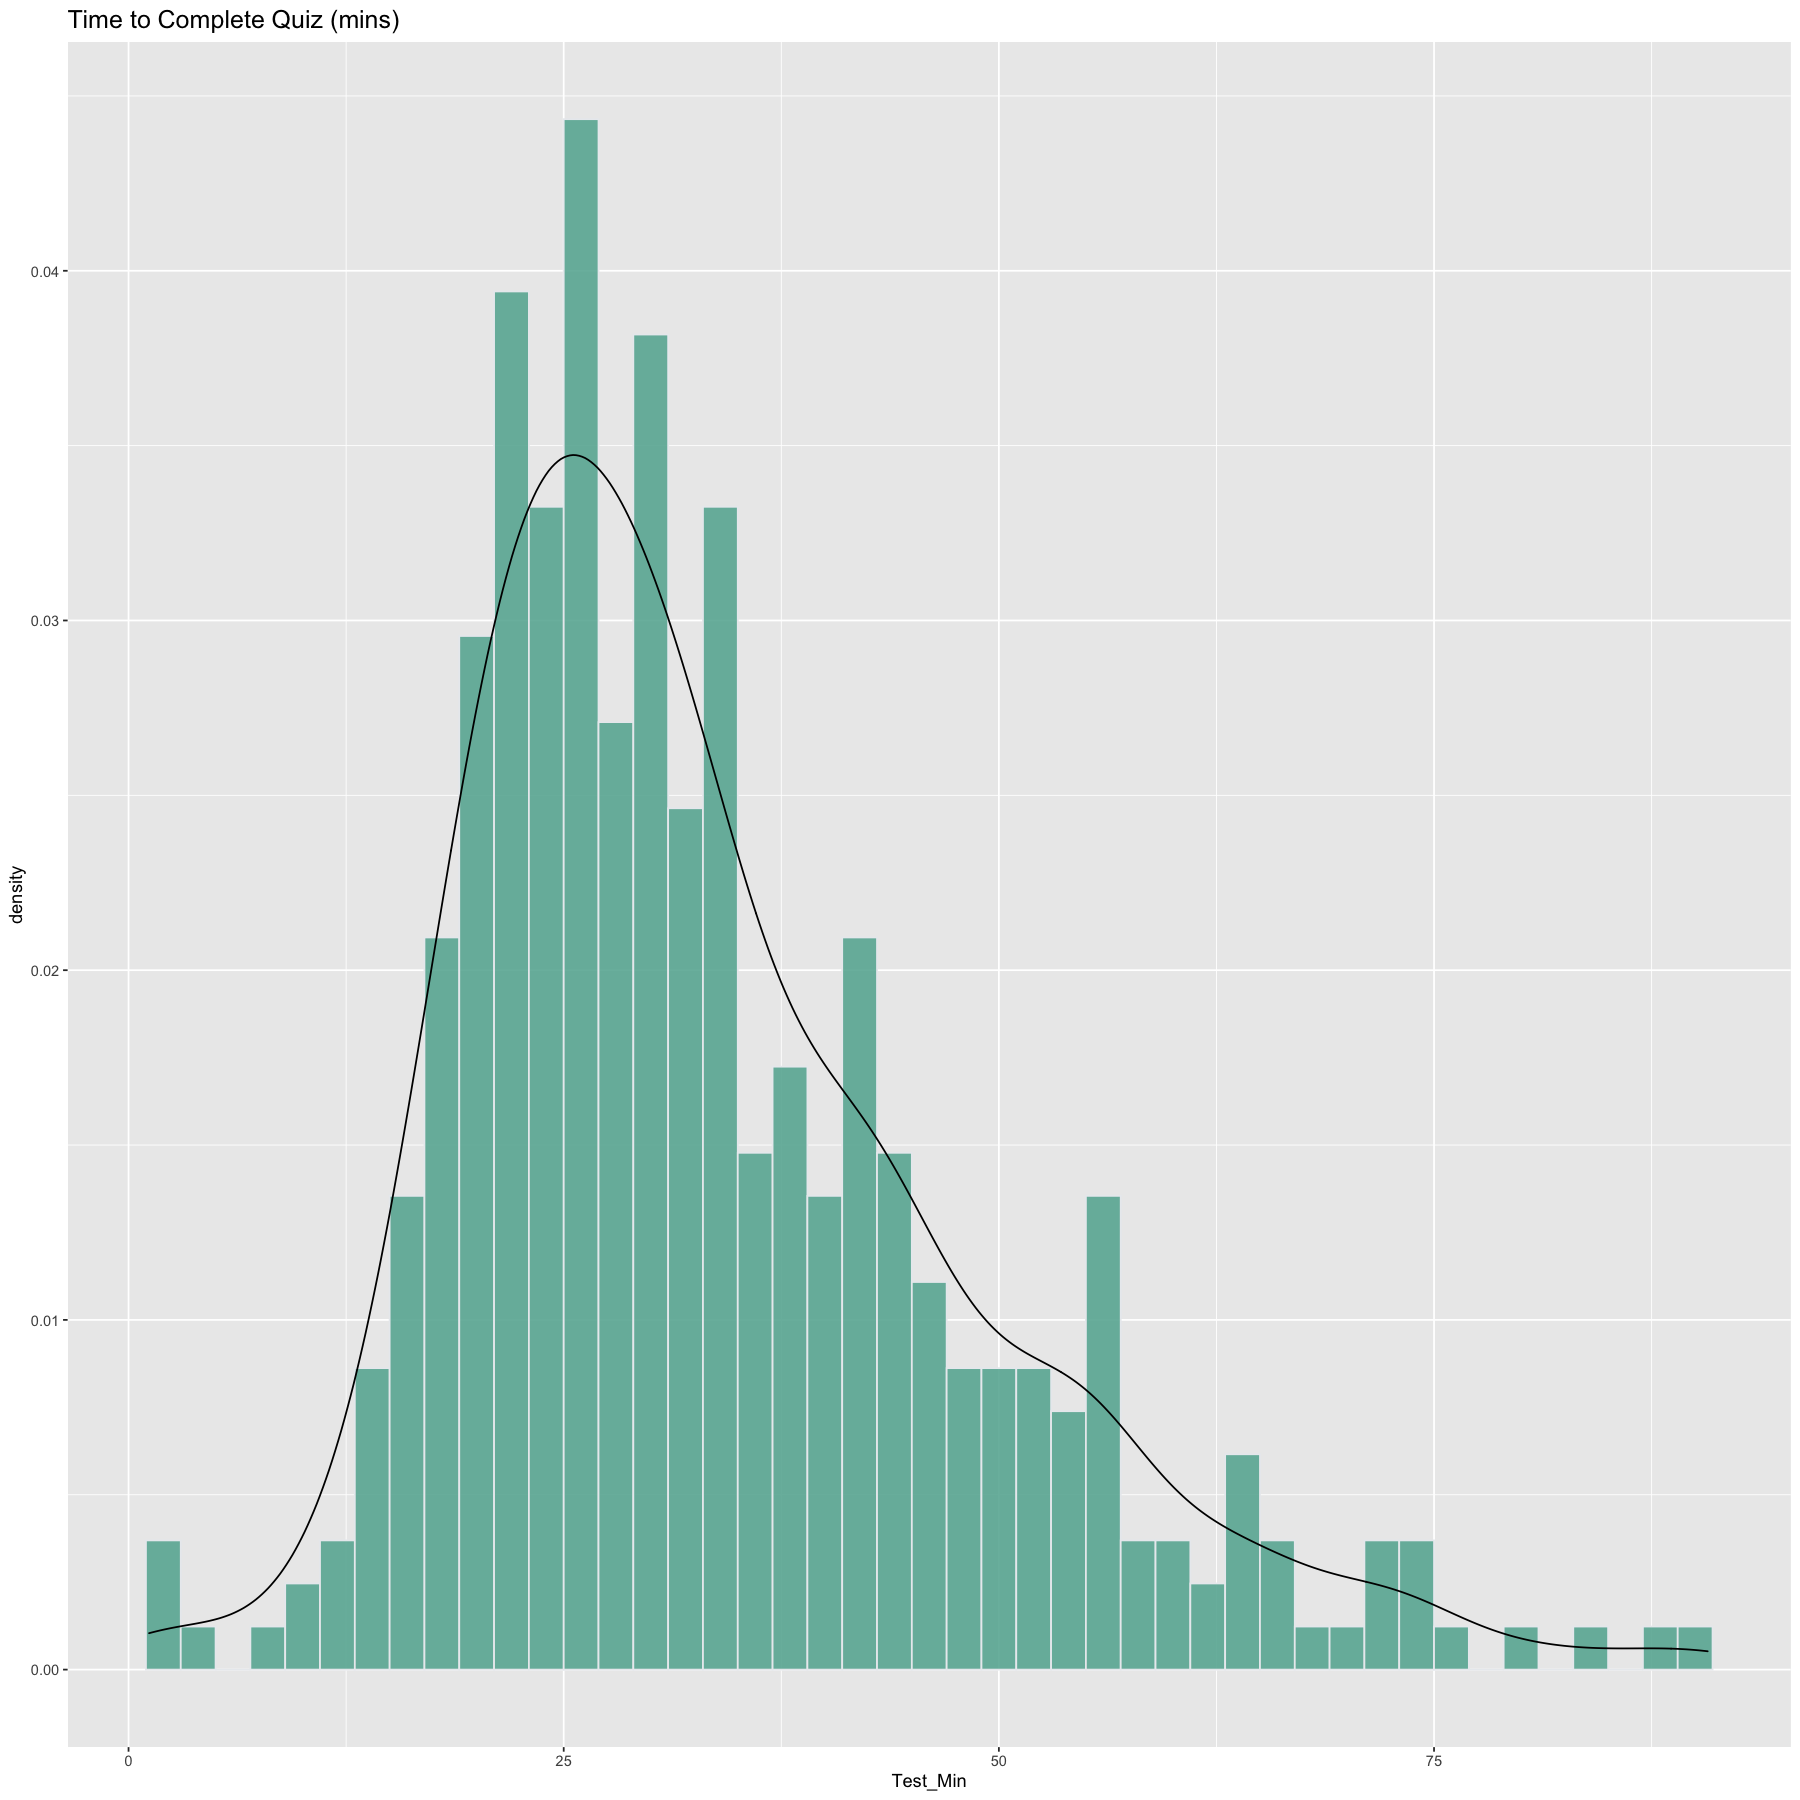

In [84]:
# Total Time on Test
tbl_test_completed_time %>%
  filter(Qs == 30) %>%
  ggplot(aes(x = Test_Min)) + 
  geom_histogram(aes(y = ..density..), binwidth=2, fill="#69b3a2", color="#e9ecef", alpha=0.9) +
  geom_density() + 
  ggtitle("Time to Complete Quiz (mins)") +
  theme(plot.title = element_text(size=15))
          


In [85]:
my_summary(
  tbl_test_completed_time$Test_Min[tbl_test_completed_time$Qs == 30]
)

n   min  q1      avg      med   q3      max  
1 406 1.18 23.1675 33.45458 30.25 41.5725 90.72

**Time spent on Python Quiz, by Question**

Warning message:
“Removed 12 rows containing missing values (geom_bar).”
Warning message:
“Removed 12 rows containing missing values (geom_bar).”


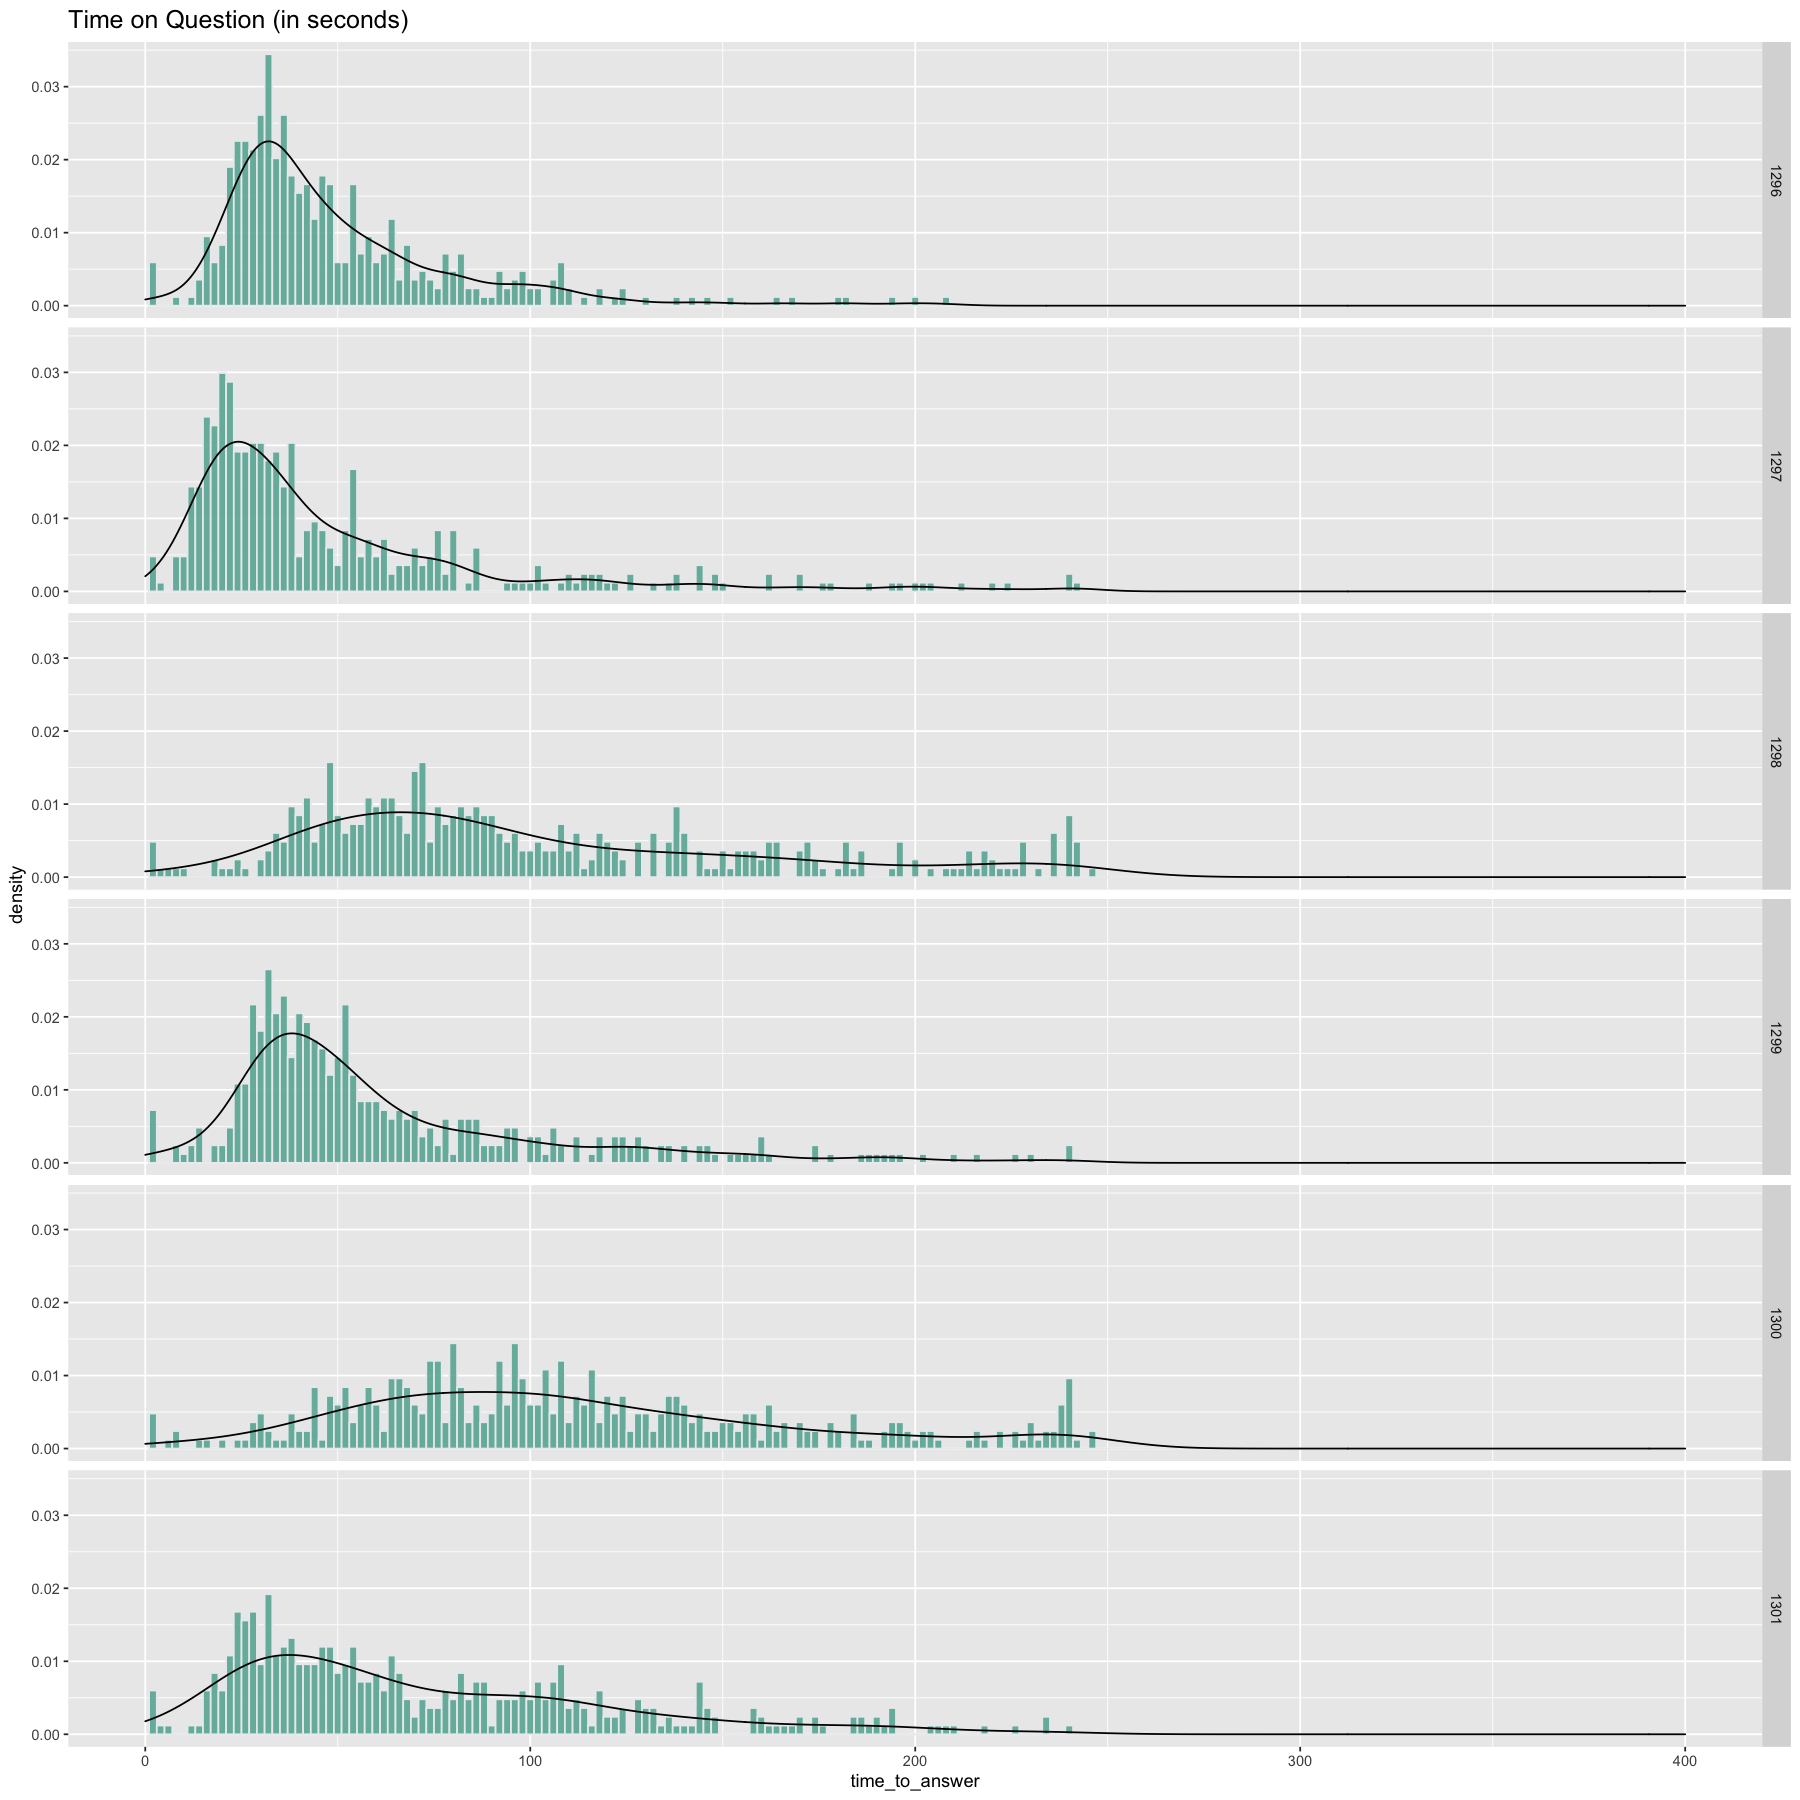

Warning message:
“Removed 12 rows containing missing values (geom_bar).”


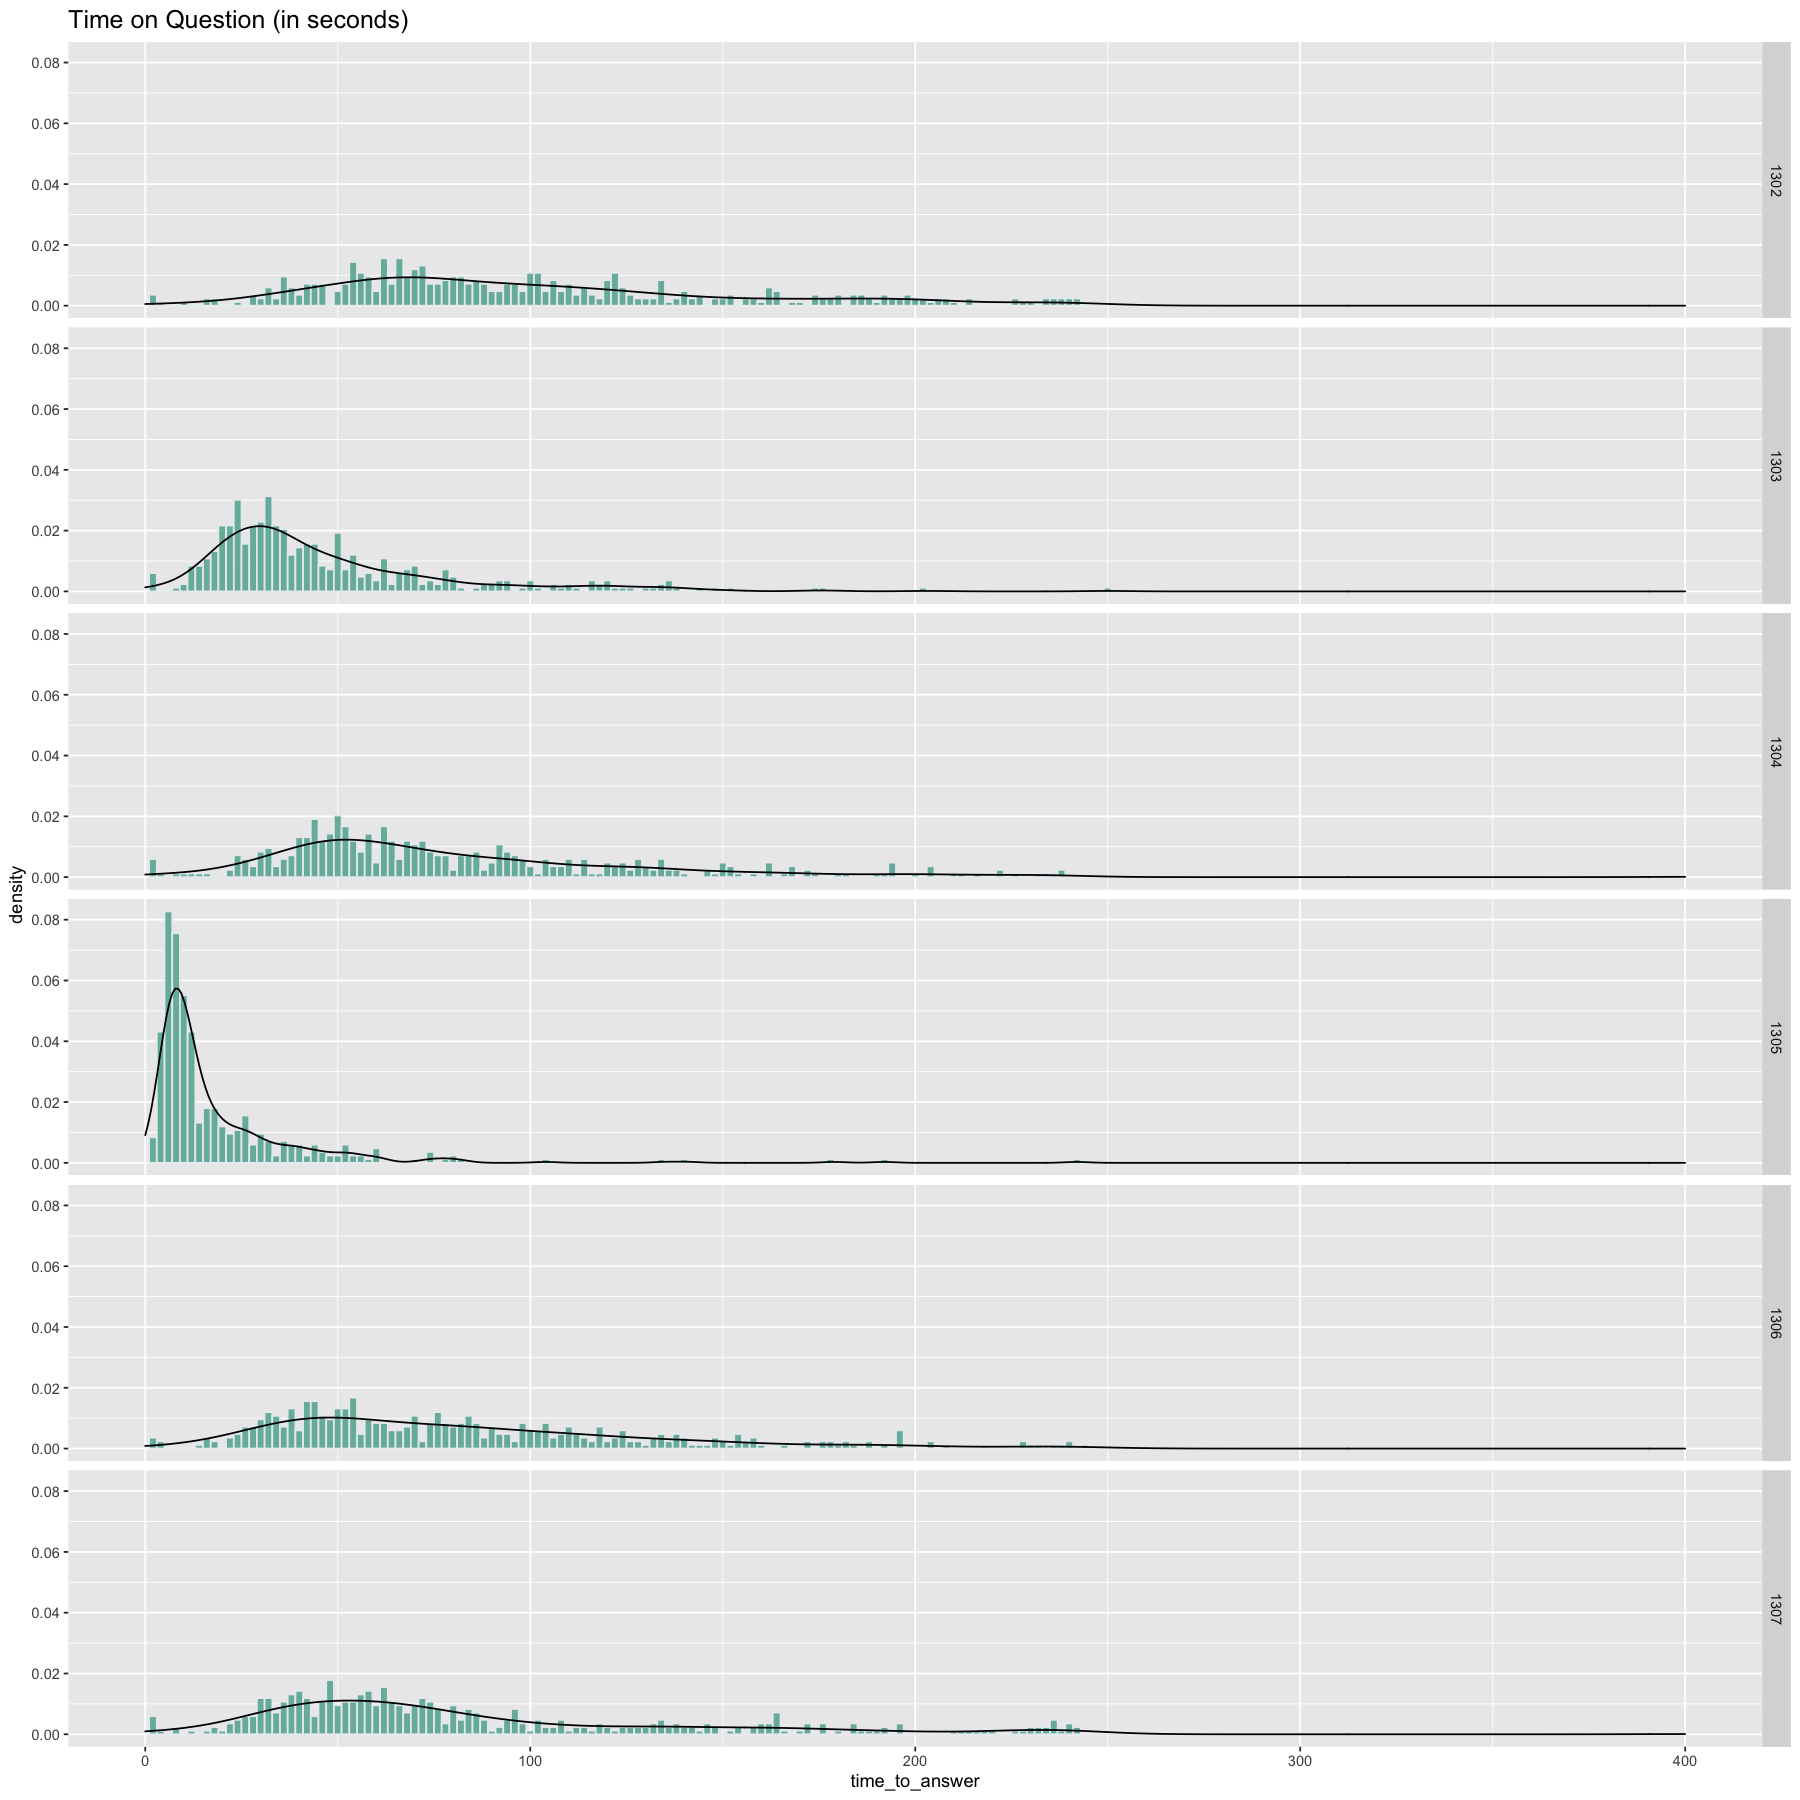

Warning message:
“Removed 12 rows containing missing values (geom_bar).”


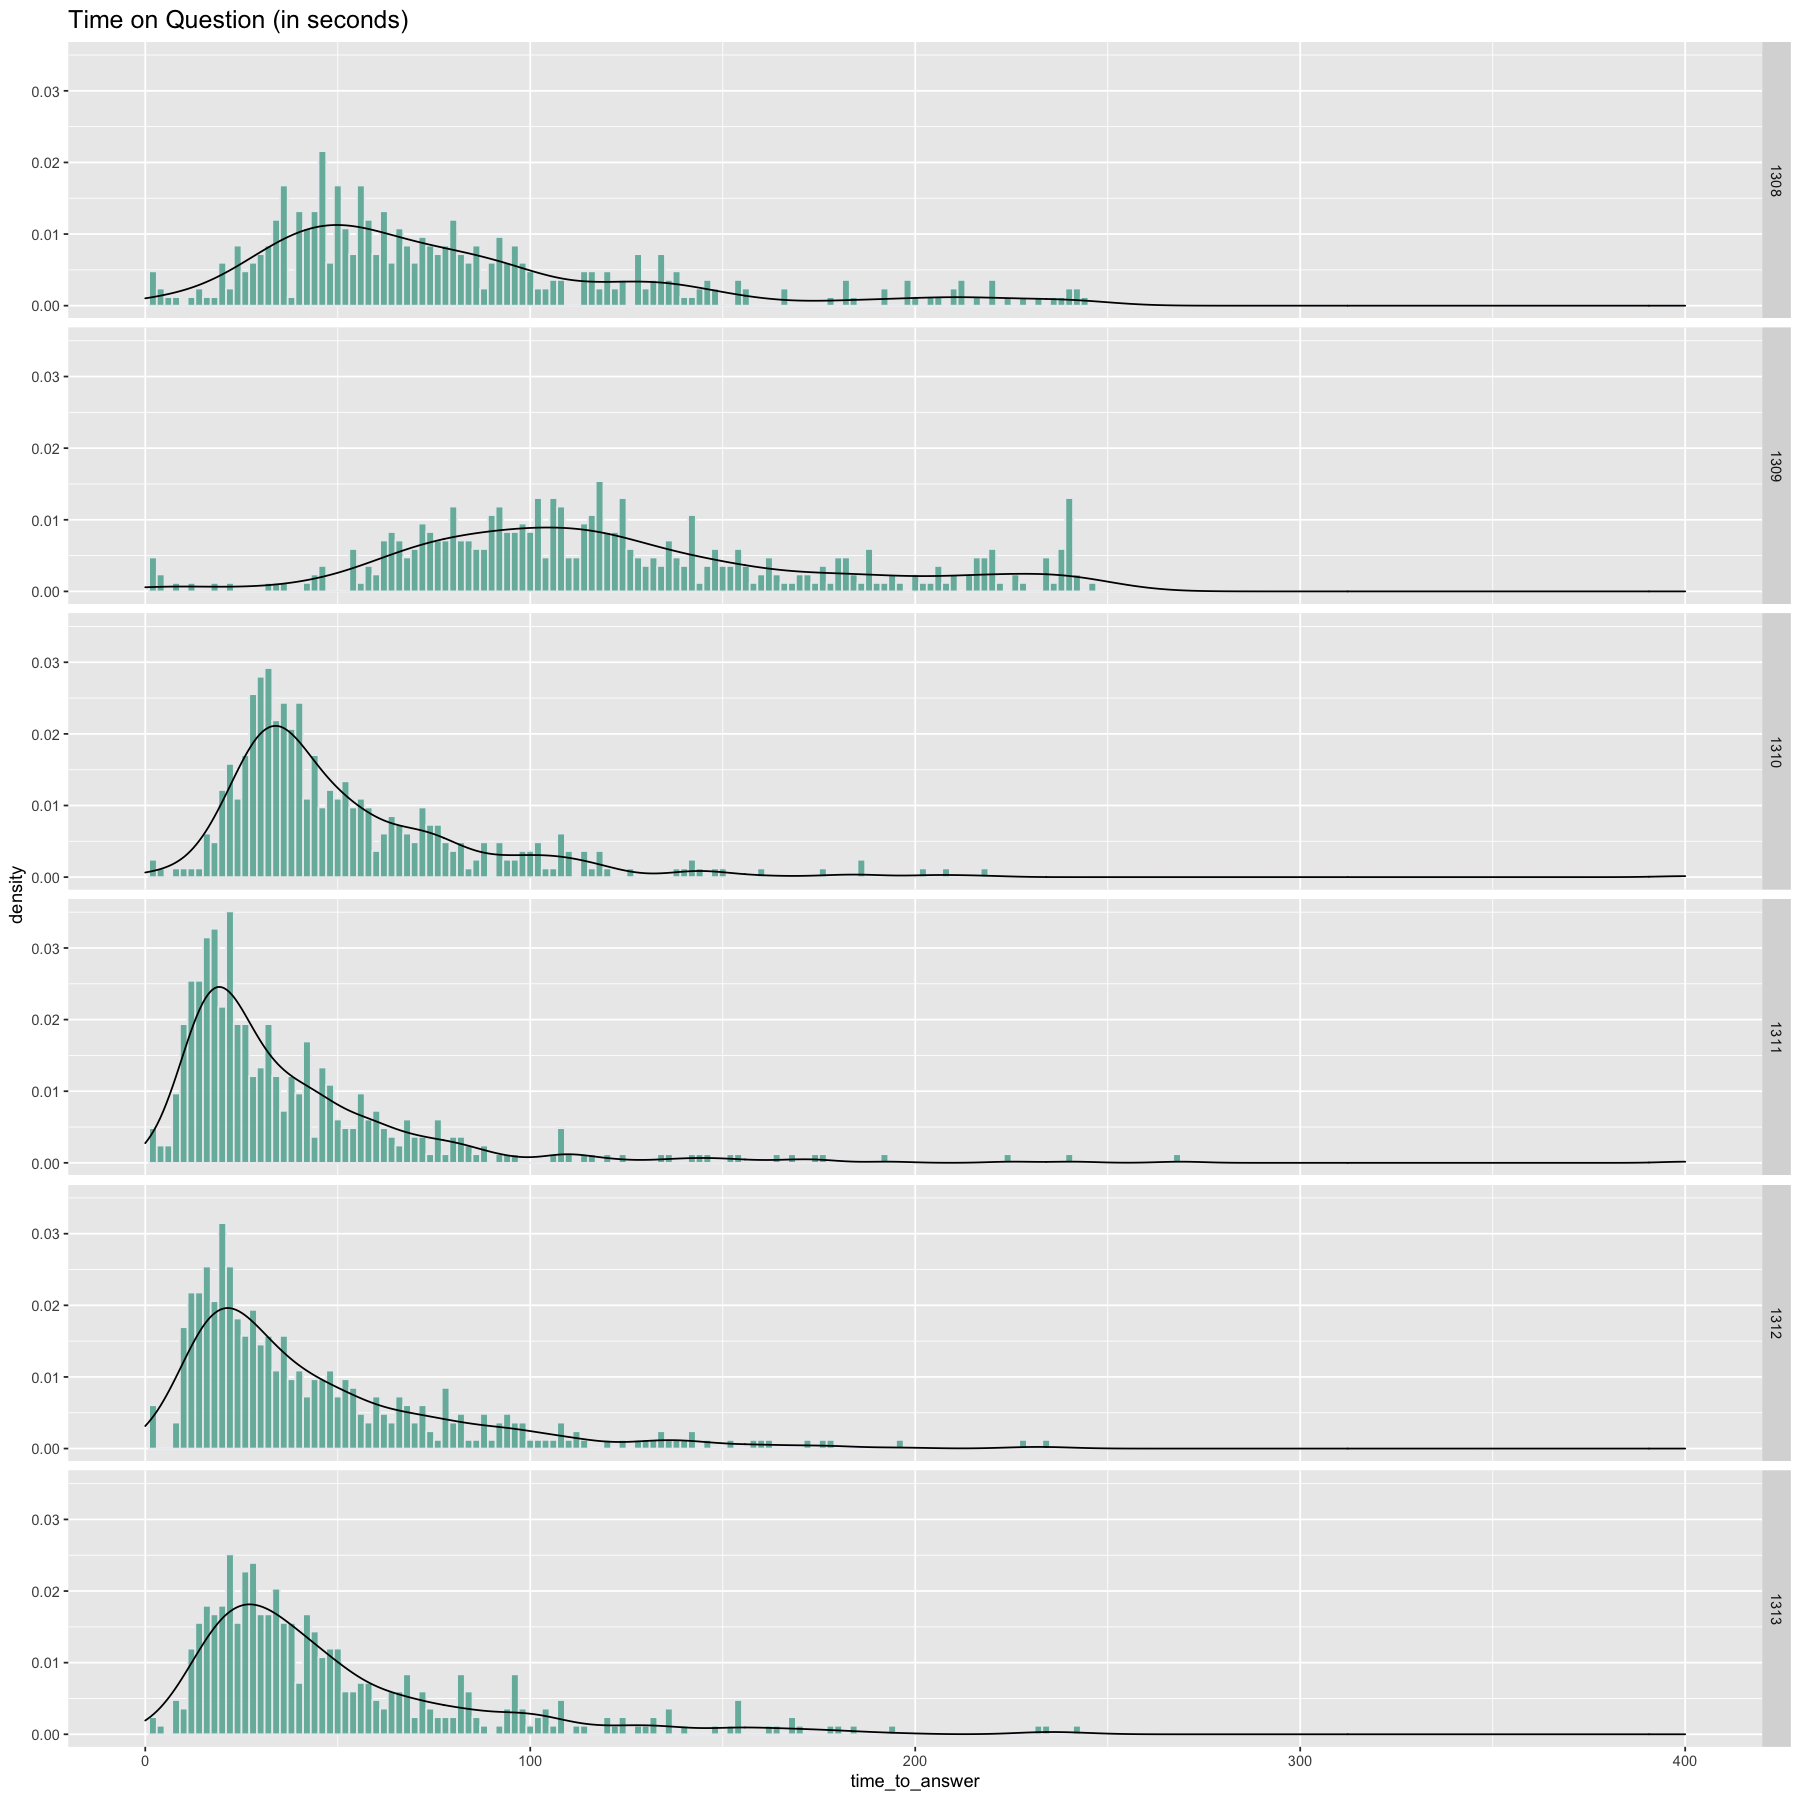

Warning message:
“Removed 12 rows containing missing values (geom_bar).”


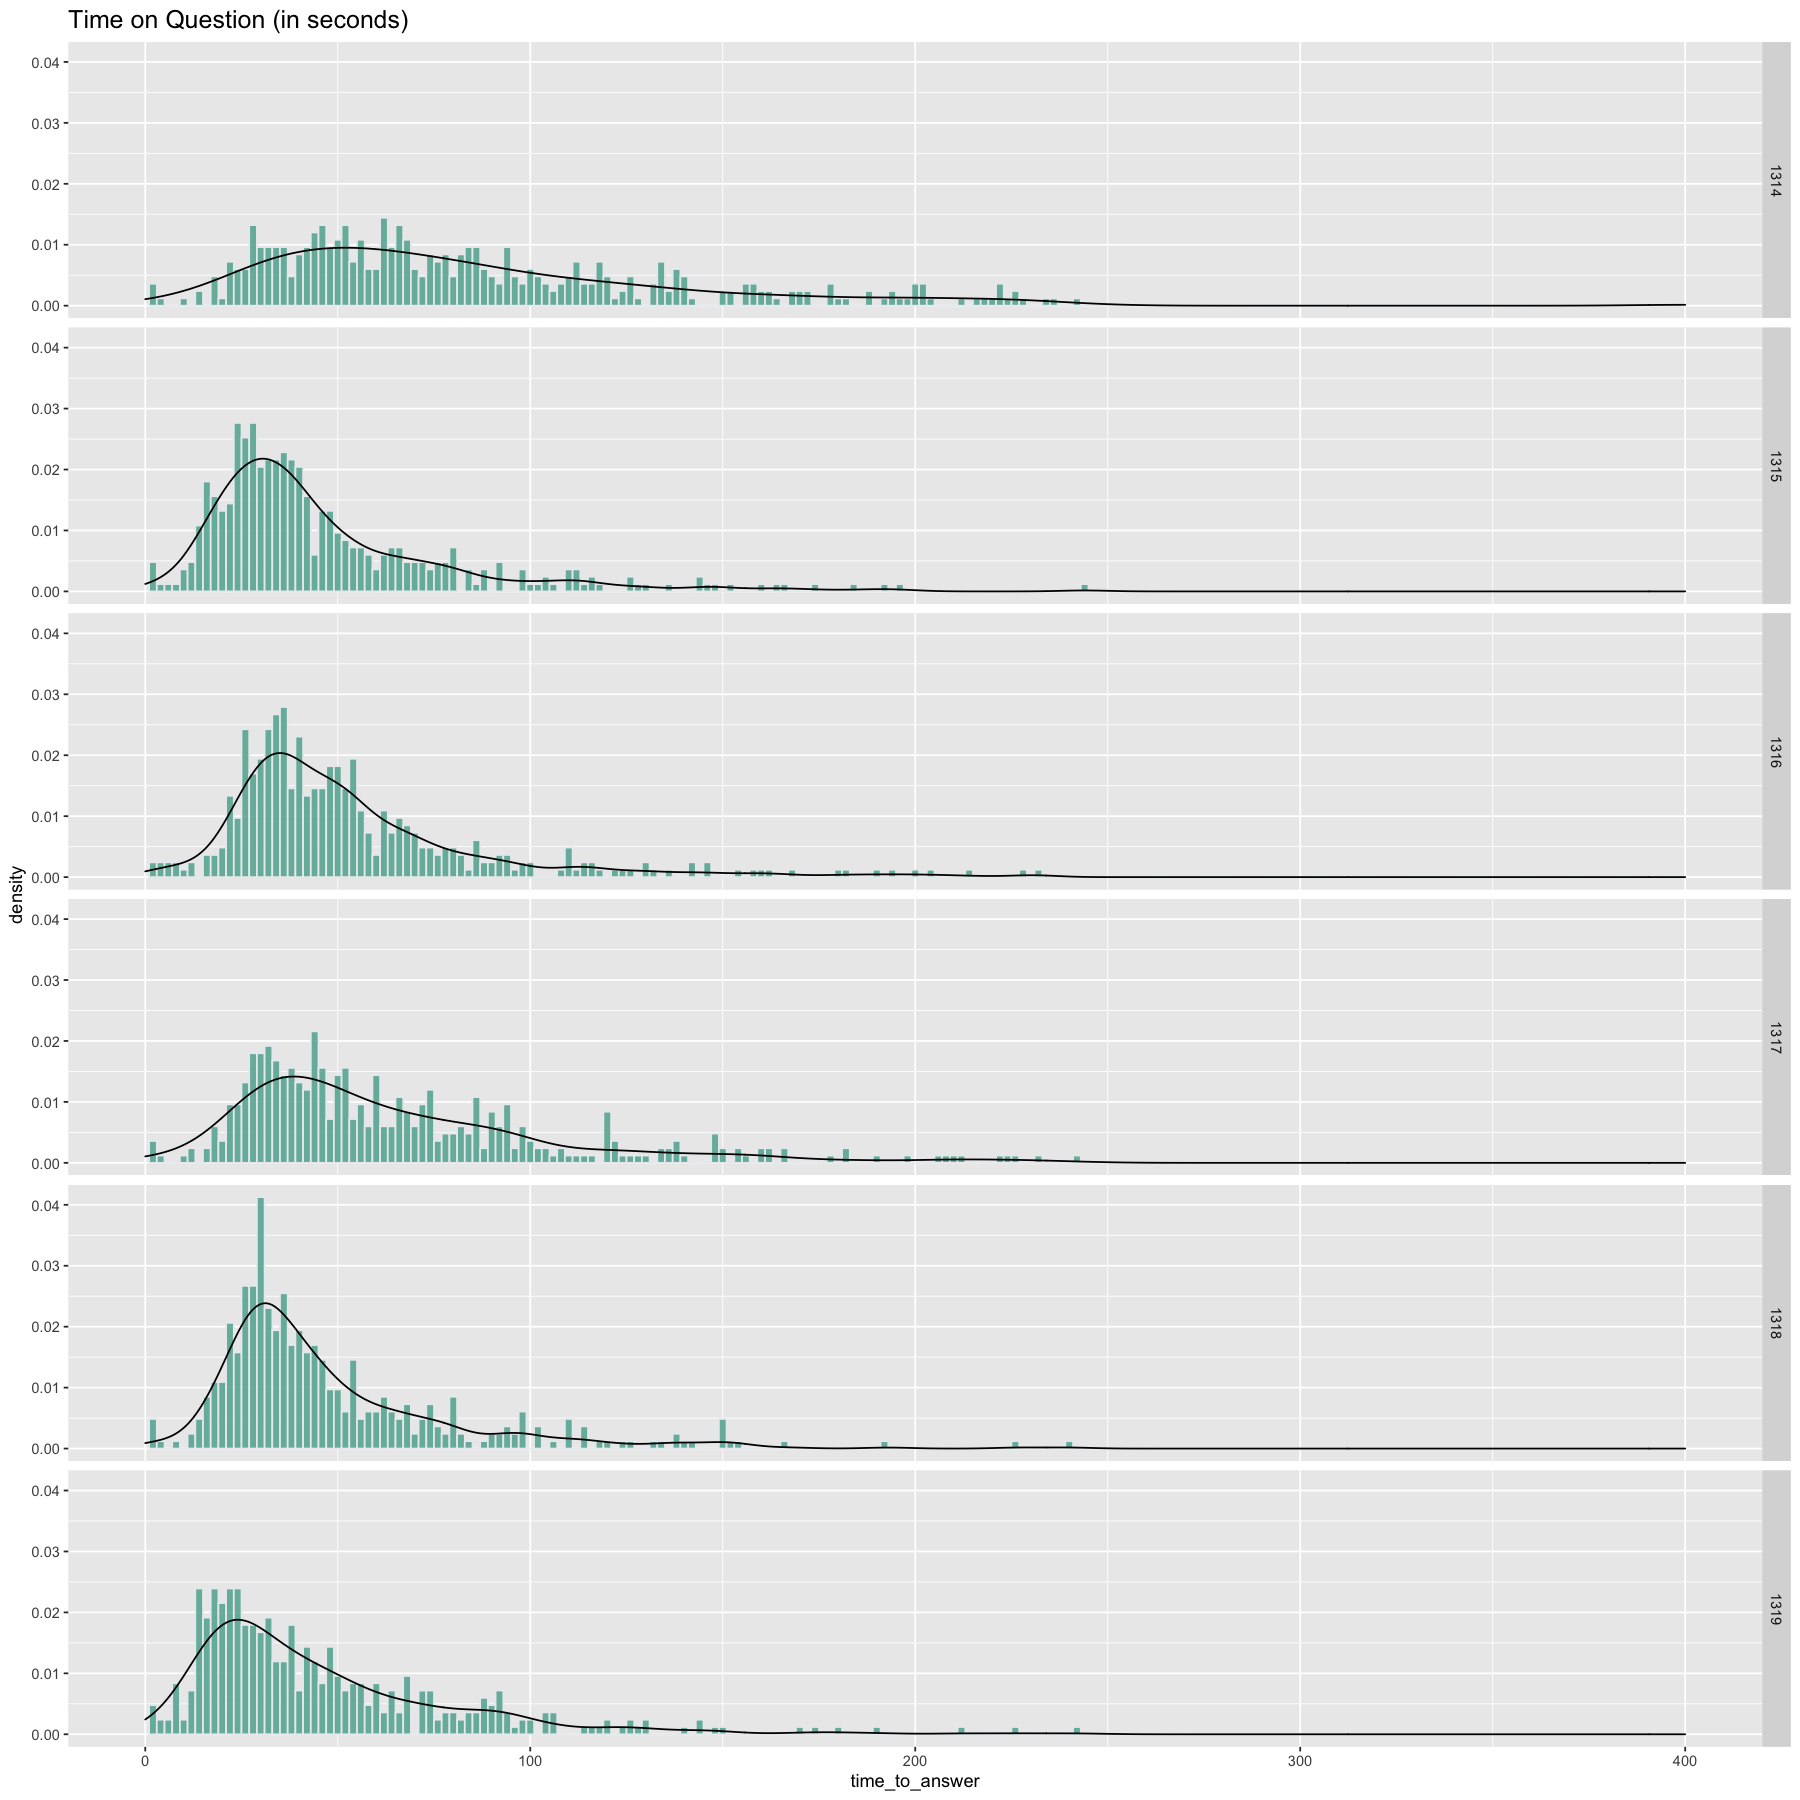

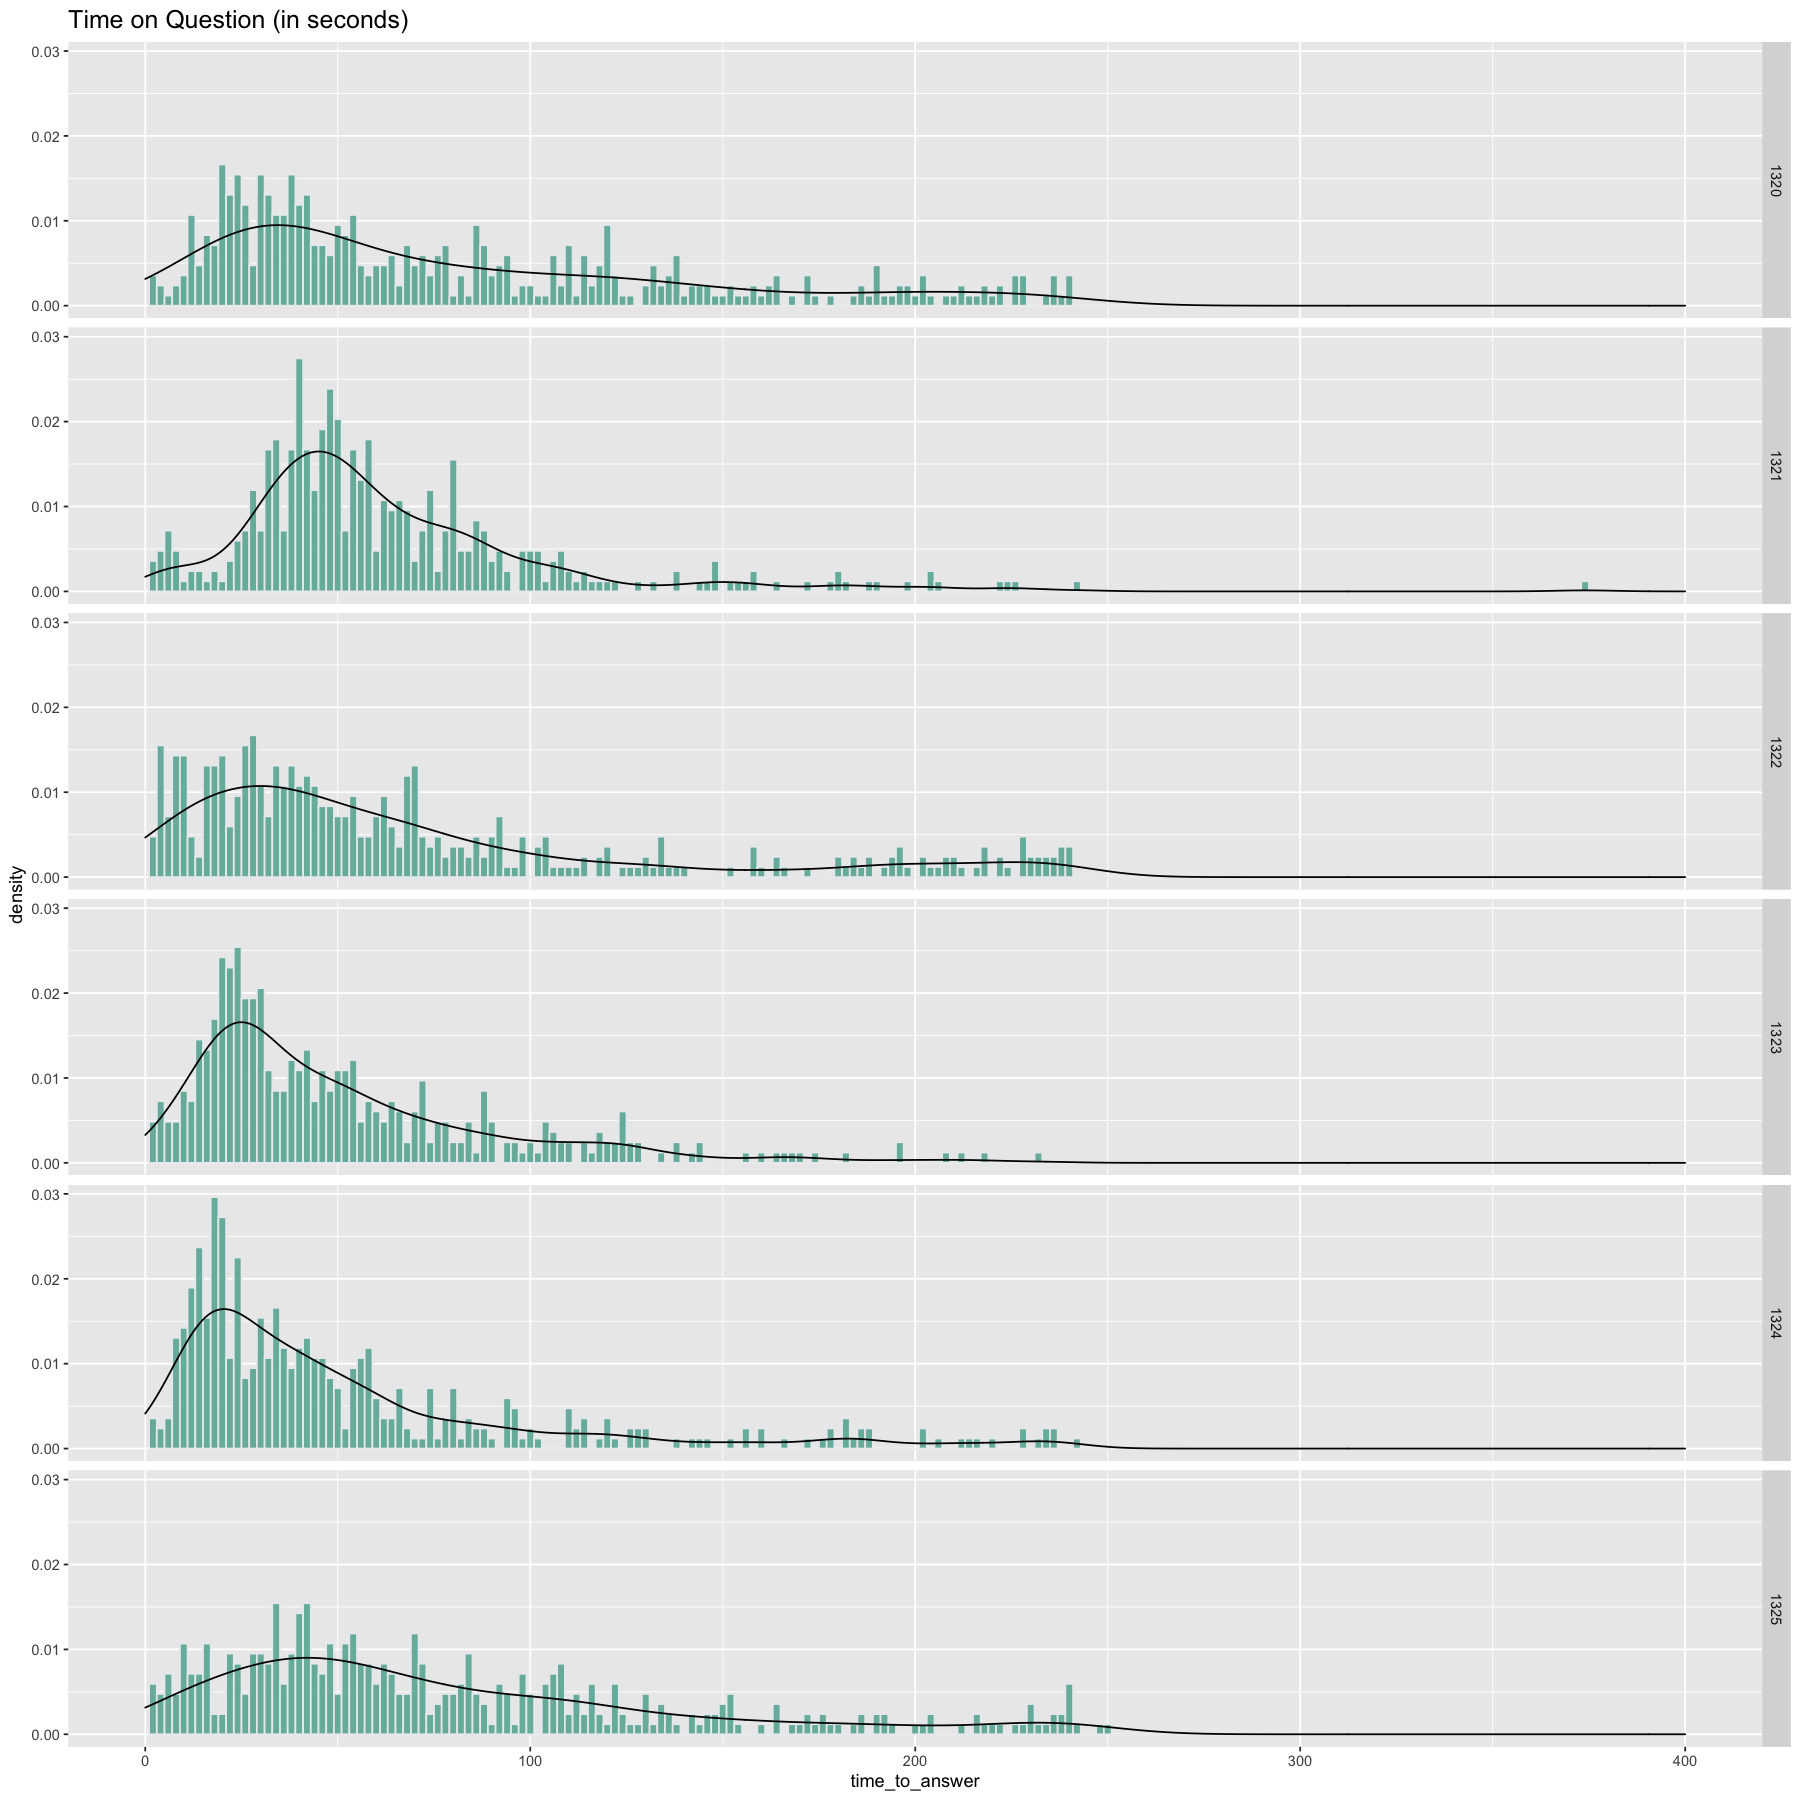

In [86]:
options(repr.plot.width=15, repr.plot.height=15)

# Plot 1
py_resp %>%
  filter( quizz_question_id <= 1301) %>%
  mutate(
    time_to_answer = if_else(time_to_answer > 400, 400L, time_to_answer)
  ) %>%
  ggplot( aes(x=time_to_answer)) +
    geom_histogram(aes(y = ..density..), binwidth=2, fill="#69b3a2", color="#e9ecef", alpha=0.9) +
  xlim(0, 400) + 
   facet_grid(quizz_question_id ~ .) + 
    ggtitle("Time on Question (in seconds)") +
    theme(plot.title = element_text(size=15)) + 
  geom_density()
  
# Plot 2
py_resp %>%
  filter( quizz_question_id > 1301 & quizz_question_id <= 1307) %>%
  mutate(
    time_to_answer = if_else(time_to_answer > 400, 400L, time_to_answer)
  ) %>%
  ggplot( aes(x=time_to_answer)) +
    geom_histogram(aes(y = ..density..), binwidth=2, fill="#69b3a2", color="#e9ecef", alpha=0.9) +
  xlim(0, 400) + 
   facet_grid(quizz_question_id ~ .) + 
    ggtitle("Time on Question (in seconds)") +
    theme(plot.title = element_text(size=15)) + 
  geom_density()
  
# Plot 3
py_resp %>%
  filter( quizz_question_id > 1307 & quizz_question_id <= 1313) %>%
  mutate(
    time_to_answer = if_else(time_to_answer > 400, 400L, time_to_answer)
  ) %>%
  ggplot( aes(x=time_to_answer)) +
    geom_histogram(aes(y = ..density..), binwidth=2, fill="#69b3a2", color="#e9ecef", alpha=0.9) +
  xlim(0, 400) + 
   facet_grid(quizz_question_id ~ .) + 
    ggtitle("Time on Question (in seconds)") +
    theme(plot.title = element_text(size=15)) + 
  geom_density()
  
# Plot 4
py_resp %>%
  filter( quizz_question_id > 1313 & quizz_question_id <= 1319) %>%
  mutate(
    time_to_answer = if_else(time_to_answer > 400, 400L, time_to_answer)
  ) %>%
  ggplot( aes(x=time_to_answer)) +
    geom_histogram(aes(y = ..density..), binwidth=2, fill="#69b3a2", color="#e9ecef", alpha=0.9) +
  xlim(0, 400) + 
   facet_grid(quizz_question_id ~ .) + 
    ggtitle("Time on Question (in seconds)") +
    theme(plot.title = element_text(size=15)) + 
  geom_density()
  
# Plot 5
py_resp %>%
  filter( quizz_question_id > 1319 & quizz_question_id <= 1325) %>%
  mutate(
    time_to_answer = if_else(time_to_answer > 400, 400L, time_to_answer)
  ) %>%
  ggplot( aes(x=time_to_answer)) +
    geom_histogram(aes(y = ..density..), binwidth=2, fill="#69b3a2", color="#e9ecef", alpha=0.9) +
  xlim(0, 400) + 
   facet_grid(quizz_question_id ~ .) + 
    ggtitle("Time on Question (in seconds)") +
    theme(plot.title = element_text(size=15)) + 
  geom_density()

### Classical Test Theory Analysis

*Item mean* is an indicator of item difficulty. Items with extremely low or high means are indicators of poorly performing items as they are overly difficult or easy, respectively, for test taskers. (parallels IRT item difficulty parameter)

*Item-total correlation* is the correlation between a score on a particular item and the performance on the rest of the test. High item-total correlations would indicate that test takers who score well on the overall test generally also performed well on the individual item. Low or negative item-total correlations are indicators of poor item performance as they suggest that test takers who score well on the overall test score lower on the individual item. This kind of item performance would suggest that the item may be measuring something different than the other items on the test or the item may be keyed in the wrong direction. (parallels IRT item discrimination parameter)

*Alpha-deleted* is a measure of the test reliability (internal consitency) - a measure of domain sampling and the impact of a flawed items if a particular item is removed. Alpha gives an estimate of average inter-item correlation among the items. An indicator of poor item performance is if once an item is removed then the overall test reliability is greatly improved.

Items are flagged to be reviewed or removed if:
 
- _Item means_ are outside of the range 0.20 and 0.80 - indicating really easy or difficult items

- _Item-total correlations_ are less than 0.20; the larger the better - indicating may be measuring something different from the rest of the test

- _Alpha-deleted_ increase if the item is removed from the test - indicating may be measuring something different from the rest of the test or is adding random noise (unsystematic variation) to the overall test.


In [87]:
# CTT ANALYSIS
ctt_results <- psych::alpha(py_resp_wide[mask_analytic_sample, -c(1:2)])
item_stats <- cbind(ctt_results$item.stats[, c(1, 6, 5)], matrix(ctt_results$alpha.drop[, 1]) )
colnames(item_stats) <- c("n_candidates", "item_mean", "item_total_correlation", "alpha_deleted")
flag <-ifelse( (item_stats$item_mean < 0.2) | 
               (item_stats$item_mean > 0.8) | 
               (item_stats$item_total_correlation < 0.2) |
               (item_stats$alpha_deleted > ctt_results$total$raw_alpha), "<=", "")

# DISTRACTOR ANALYSIS
df_distractors <- py_responses %>%
  select(candidate_id, try_count, created_at, quizz_question_id, answer_number, time_to_answer) %>%
  mutate(created_at = as.POSIXct(str_replace(created_at, "T", " "), format = "%Y-%m-%d %H:%M")) %>%
  filter(candidate_id > 80) %>%
  mutate(
    answer_number = as.numeric(answer_number),
    quizz_question_id = as.character(quizz_question_id)
  ) %>%
  select(-created_at, -time_to_answer) %>%
  distinct(candidate_id, try_count, quizz_question_id, .keep_all = TRUE) %>%
  pivot_wider(id_cols = c(candidate_id, try_count),
              names_from = quizz_question_id,
              values_from = answer_number)

ctt_distractors <- psych::alpha(df_distractors[mask_analytic_sample, -c(1:2)])

# DISPLAY
paste0("Overall Quiz Reliability is: ",
               round(ctt_results$total$raw_alpha, 3), sep = "" )

cbind(df_blueprint$question_id,
    flag, 
    df_blueprint[, -c(1:2)],
    round(item_stats, 3),
    round(ctt_distractors$response.freq, 3)
    ) %>% 
    arrange(claim, name)


[1] "Overall Quiz Reliability is: 0.815"

df_blueprint$question_id flag claim   name          
1  1296                     <=   Claim 1 lang_python_01
2  1297                     <=   Claim 1 lang_python_02
3  1298                          Claim 1 lang_python_03
4  1299                     <=   Claim 1 lang_python_04
5  1300                          Claim 1 lang_python_05
6  1301                          Claim 1 lang_python_06
7  1302                          Claim 2 lang_python_07
8  1303                     <=   Claim 2 lang_python_08
9  1304                          Claim 2 lang_python_09
10 1305                     <=   Claim 2 lang_python_10
11 1306                          Claim 2 lang_python_11
12 1307                     <=   Claim 2 lang_python_12
13 1308                     <=   Claim 2 lang_python_13
14 1309                          Claim 3 lang_python_14
15 1310                     <=   Claim 3 lang_python_15
16 1311                          Claim 3 lang_python_16
17 1312                          Claim 3 lang_python_17
18 1313                          Claim 3 lang_python_18
19 1314                     <=   Claim 4 lang_python_19
20 1315                     <=   Claim 4 lang_python_20
21 1316                     <=   Claim 4 lang_python_21
22 1317                          Claim 4 lang_python_22
23 1318                     <=   Claim 4 lang_python_23
24 1319                          Claim 4 lang_python_24
25 1320                          Claim 5 lang_python_25
26 1321                     <=   Claim 5 lang_python_26
27 1322                          Claim 5 lang_python_27
28 1323                          Claim 5 lang_python_28
29 1324                     <=   Claim 5 lang_python_29
30 1325                          Claim 5 lang_python_30
   target                     n_candidates item_mean item_total_correlation
1  `for loops`                389          0.900     0.335                 
2  `lamda function`           389          0.856     0.445                 
3  `variable`                 389          0.725     0.324                 
4  `strings`                  389          0.830     0.249                 
5  `String`                   389          0.697     0.367                 
6  `zip`                      389          0.779     0.258                 
7  `classes`                  389          0.712     0.465                 
8  `classes`                  389          0.851     0.312                 
9  `iterators`                389          0.607     0.269                 
10 NA                         389          0.913     0.288                 
11 `string`                   389          0.751     0.312                 
12 `classes`                  389          0.853     0.414                 
13 `dictionary-comprehension` 389          0.856     0.411                 
14 `dictionary`               389          0.545     0.492                 
15 `list-comprehension`       389          0.859     0.395                 
16 `read-json`                389          0.530     0.381                 
17 `static-method`            389          0.702     0.414                 
18 `write-file`               389          0.622     0.211                 
19 `function args`            389          0.802     0.409                 
20 `error-handing`            389          0.913     0.216                 
21 `import-module`            389          0.866     0.397                 
22 `name-main`                389          0.769     0.268                 
23 `name-space`               389          0.974     0.327                 
24 `requirements-txt`         389          0.728     0.458                 
25 `datetime`                 389          0.452     0.259                 
26 `flask`                    389          0.879     0.286                 
27 `numpy`                    389          0.483     0.249                 
28 `numpy`                    389          0.645     0.283                 
29 `requests`                 389          0.620     0.187     

### IRT Analysis

#### Unidimensional Model

In [88]:
#mod1_unidim <- mirt( py_resp_wide[mask_analytic_sample, -c(1:2)], 1, SE = TRUE)
model <- 'F = 1-30
          PRIOR = (1-30, a1, lnorm, 0, 1), (1-30, d, norm, 0, 1)'
mod1_unidim <- mirt(py_resp_wide[mask_analytic_sample, -c(1:2)], model, SE = TRUE)

mod1_unidim

Iteration: 22, Log-Lik: -5621.900, Max-Change: 0.00008

Calculating information matrix...



Call:
mirt(data = py_resp_wide[mask_analytic_sample, -c(1:2)], model = model, 
    SE = TRUE)

Full-information item factor analysis with 1 factor(s).
Converged within 1e-04 tolerance after 22 EM iterations.
mirt version: 1.32.1 
M-step optimizer: nlminb 
EM acceleration: Ramsay 
Number of rectangular quadrature: 61
Latent density type: Gaussian 

Information matrix estimated with method: Oakes
Second-order test: model is a possible local maximum
Condition number of information matrix =  19.5315

Log-posterior = -5621.898
Estimated parameters: 60 
DIC = 11363.8
G2 (1073741763) = 6488.2, p = 1
RMSEA = 0, CFI = NaN, TLI = NaN

#### IRT Item Parameters

Add definition of `a` and `b` parameters for general reference. 

In [89]:
mod1_coef <- coef(mod1_unidim, simplify = TRUE, IRTpars = TRUE)$items

round(cbind(mod1_coef), 3)

a     b      g u
1314 1.255 -1.297 0 1
1303 1.012 -1.893 0 1
1311 1.088 -0.021 0 1
1296 1.106 -2.219 0 1
1308 1.402 -1.542 0 1
1302 1.426 -0.744 0 1
1297 1.620 -1.413 0 1
1310 1.259 -1.674 0 1
1307 1.387 -1.534 0 1
1306 0.810 -1.416 0 1
1316 1.294 -1.702 0 1
1300 0.980 -0.891 0 1
1325 0.607  1.032 0 1
1319 1.334 -0.852 0 1
1298 0.950 -1.081 0 1
1317 0.703 -1.750 0 1
1324 0.448 -1.017 0 1
1321 0.861 -2.448 0 1
1323 0.620 -0.928 0 1
1313 0.547 -0.854 0 1
1318 1.255 -3.106 0 1
1309 1.785 -0.042 0 1
1299 0.697 -2.348 0 1
1322 0.574  0.236 0 1
1304 0.702 -0.568 0 1
1315 0.699 -3.429 0 1
1301 0.714 -1.814 0 1
1320 0.617  0.446 0 1
1312 1.193 -0.791 0 1
1305 0.968 -2.613 0 1

#### Item Fit Statistics (S-X2):  p-val < 0.05 <=> generally indicaties model misfit

In [90]:
mod1_item_fit <- itemfit(mod1_unidim, na.rm = T)
flag <- ifelse(
  mod1_item_fit$p.S_X2 < 0.05, "<=", ""
)

cbind(df_blueprint[, -c(1,2)],
            mod1_item_fit,
            flag)

Data does not contain missing values. Continuing normally

Sample size after row-wise response data removal: 389



claim   name           target                     item S_X2      df.S_X2
1  Claim 4 lang_python_19 `function args`            1314 12.468512 16     
2  Claim 2 lang_python_08 `classes`                  1303 21.258556 17     
3  Claim 3 lang_python_16 `read-json`                1311 18.998704 14     
4  Claim 1 lang_python_01 `for loops`                1296 10.123755 16     
5  Claim 2 lang_python_13 `dictionary-comprehension` 1308 12.140880 15     
6  Claim 2 lang_python_07 `classes`                  1302 12.187014 15     
7  Claim 1 lang_python_02 `lamda function`           1297 14.605450 15     
8  Claim 3 lang_python_15 `list-comprehension`       1310 18.852472 15     
9  Claim 2 lang_python_12 `classes`                  1307 31.497579 15     
10 Claim 2 lang_python_11 `string`                   1306  9.342893 17     
11 Claim 4 lang_python_21 `import-module`            1316 14.703262 15     
12 Claim 1 lang_python_05 `String`                   1300 18.773763 17     
13 Claim 5 lang_python_30 `pandas`                   1325 21.868289 16     
14 Claim 4 lang_python_24 `requirements-txt`         1319 11.347844 15     
15 Claim 1 lang_python_03 `variable`                 1298 21.759647 17     
16 Claim 4 lang_python_22 `name-main`                1317 20.986913 18     
17 Claim 5 lang_python_29 `requests`                 1324 22.346964 19     
18 Claim 5 lang_python_26 `flask`                    1321  9.822743 17     
19 Claim 5 lang_python_28 `numpy`                    1323 23.426272 17     
20 Claim 3 lang_python_18 `write-file`               1313 27.796398 17     
21 Claim 4 lang_python_23 `name-space`               1318  9.234797  6     
22 Claim 3 lang_python_14 `dictionary`               1309 11.257256 12     
23 Claim 1 lang_python_04 `strings`                  1299  6.918439 18     
24 Claim 5 lang_python_27 `numpy`                    1322 26.146676 17     
25 Claim 2 lang_python_09 `iterators`                1304 15.888630 17     
26 Claim 4 lang_python_20 `error-handing`            1315 20.122813 16     
27 Claim 1 lang_python_06 `zip`                      1301 19.057648 18     
28 Claim 5 lang_python_25 `datetime`                 1320 22.801261 16     
29 Claim 3 lang_python_17 `static-method`            1312 22.723027 16     
30 Claim 2 lang_python_10 NA                         1305  9.999393 16     
   RMSEA.S_X2 p.S_X2      flag
1  0.00000000 0.711148046     
2  0.02540919 0.214938073     
3  0.03033534 0.164998789     
4  0.00000000 0.860086065     
5  0.00000000 0.668335682     
6  0.00000000 0.664821864     
7  0.00000000 0.480192576     
8  0.02572813 0.220497142     
9  0.05324130 0.007531207 <=  
10 0.00000000 0.928886452     
11 0.00000000 0.472995470     
12 0.01639863 0.341671479     
13 0.03074538 0.147495456     
14 0.00000000 0.727569186     
15 0.02686254 0.194139994     
16 0.02068041 0.280073841     
17 0.02130752 0.267330192     
18 0.00000000 0.910878457     
19 0.03121327 0.135880718     
20 0.04045751 0.047374168 <=  
21 0.03727624 0.160797451     
22 0.00000000 0.507010023     
23 0.00000000 0.990796277     
24 0.03723843 0.071829389     
25 0.00000000 0.531743366     
26 0.02577039 0.214740067     
27 0.01230604 0.388281638     
28 0.03309930 0.119151440     
29 0.03290839 0.121341632     
30 0.00000000 0.866660000

Items are flagged with '<=' to be reviewed or removed if _p-value_ < 0.05. This indicates poor fit of 2PL model.

## IRT Plots

#### Item Local-Dependence Plots - Residual Dependencies given a unidimensional model:

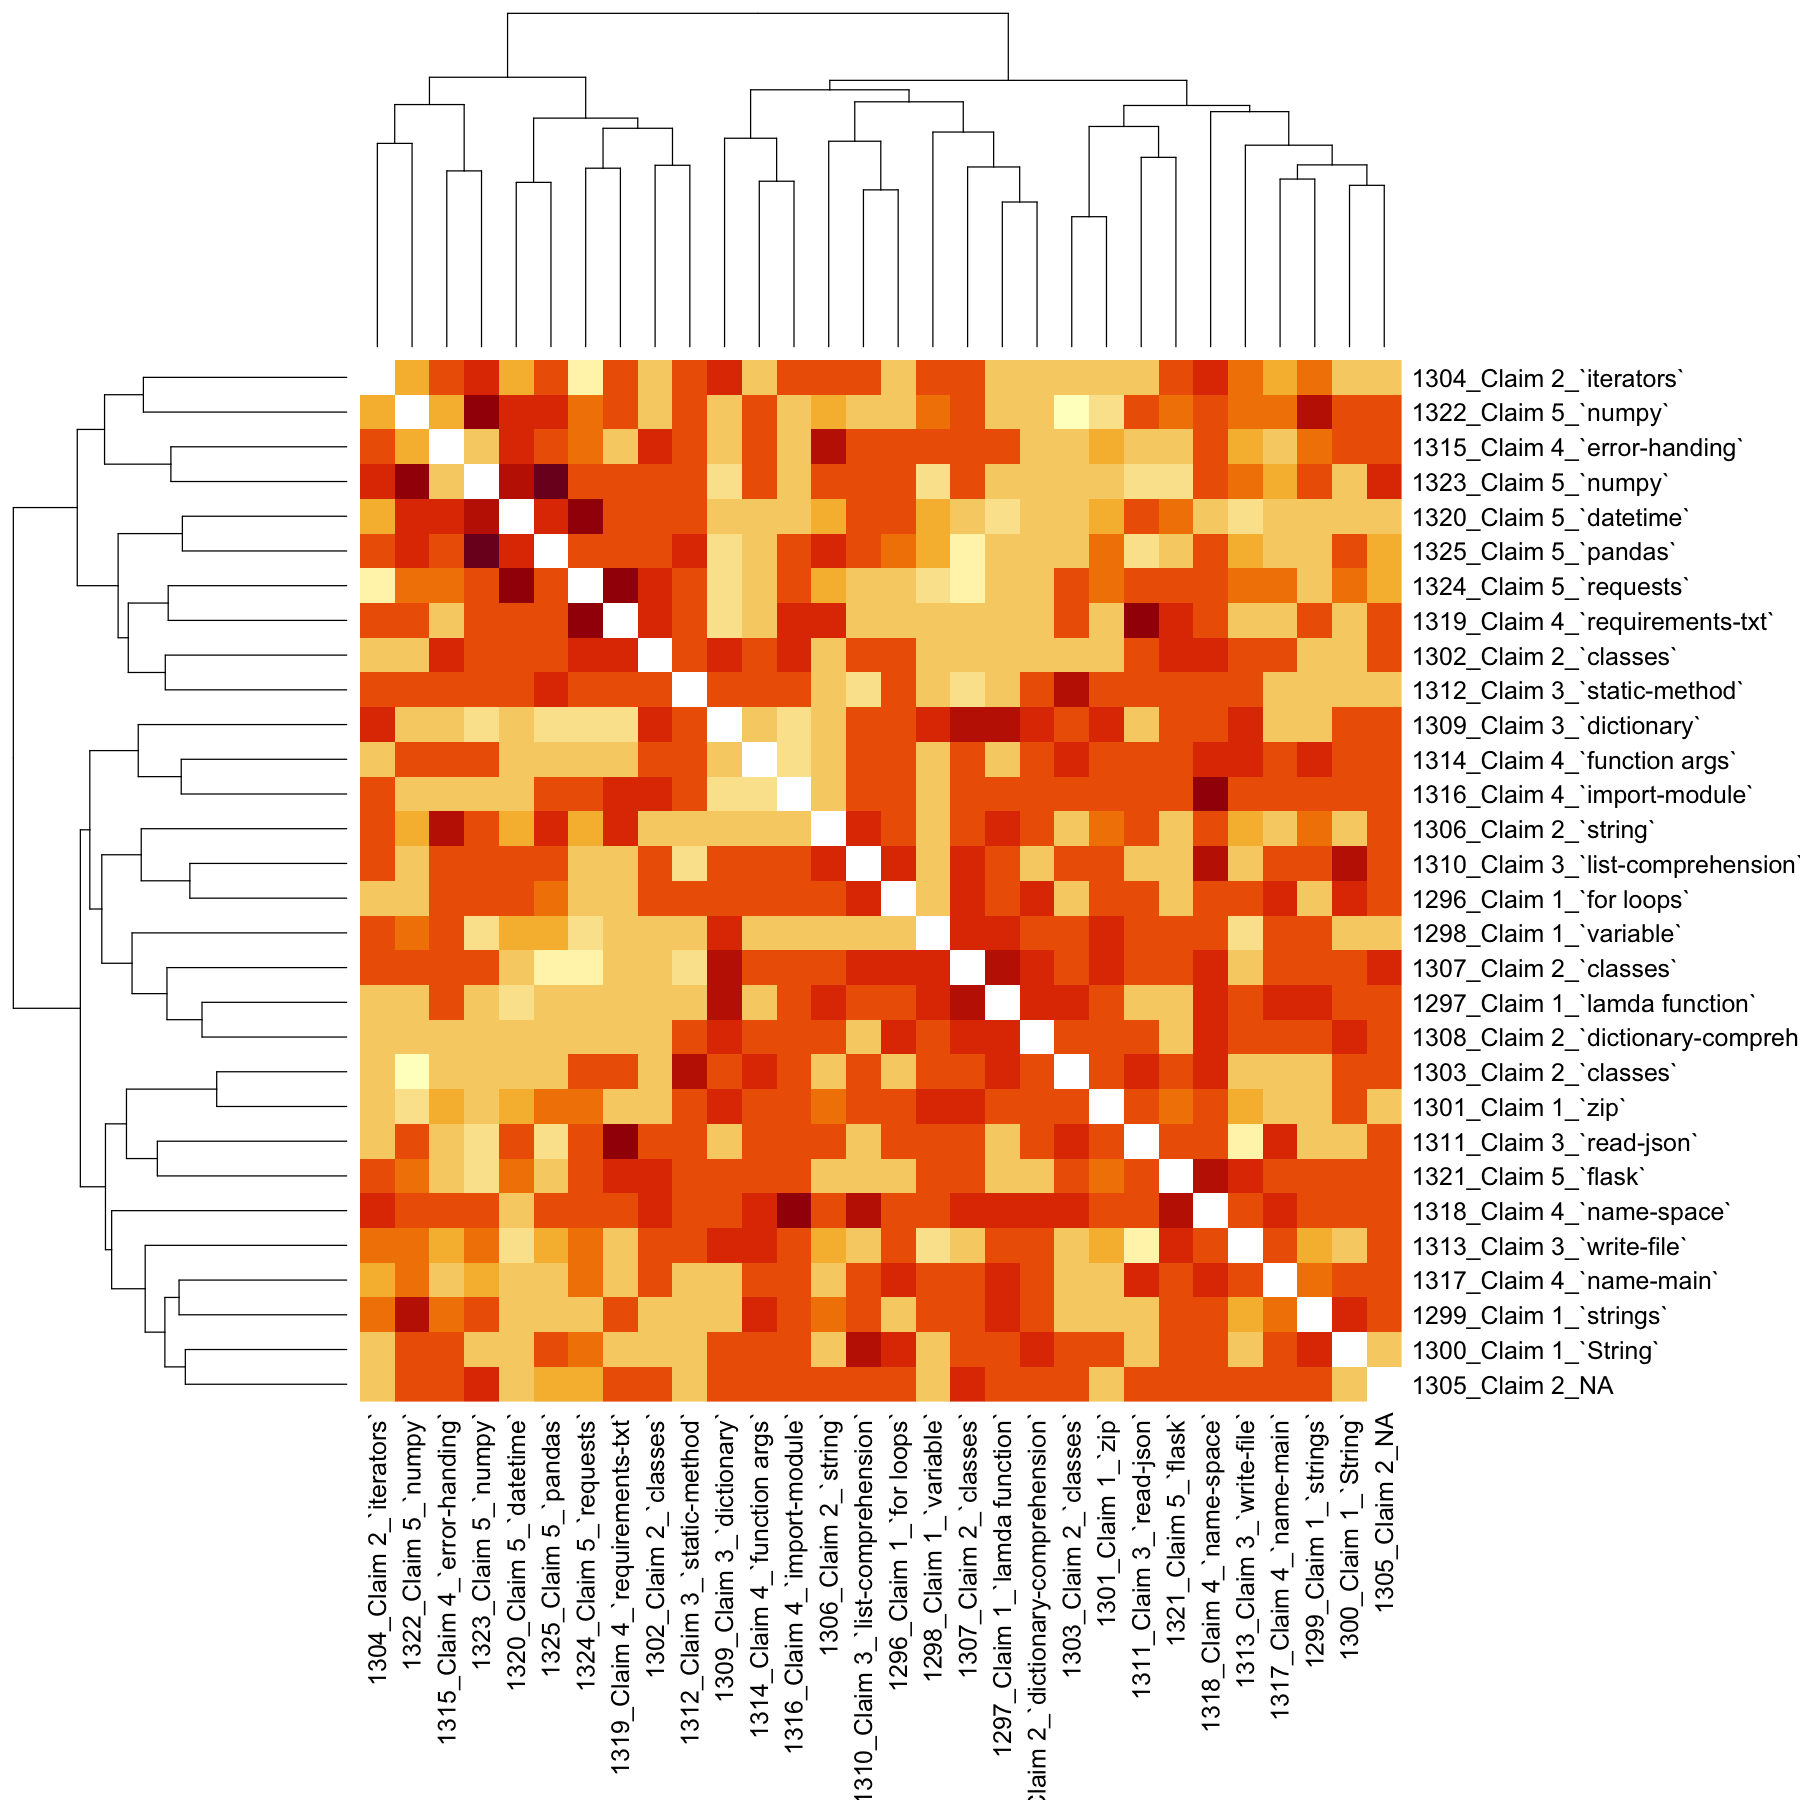

In [91]:
mod1_residuals <- residuals(mod1_unidim, type = "LD", df.p = TRUE, verbose = FALSE)

mod1_LD <- mod1_residuals$LD * upper.tri(mod1_residuals$LD)  + t(mod1_residuals$LD * upper.tri(mod1_residuals$LD))

colnames(mod1_LD) <- paste(df_blueprint$question_id, "_", df_blueprint$claim, "_", df_blueprint$target, sep = "")
rownames(mod1_LD) <- paste(df_blueprint$question_id, "_", df_blueprint$claim, "_", df_blueprint$target, sep = "")

options(repr.plot.width=15, repr.plot.height=15)
heatmap(mod1_LD, cexRow = 1.5, cexCol = 1.5, symm = TRUE, margins = c(20, 20))

#### Item Characteristic Curves (Tracelines), by Claims

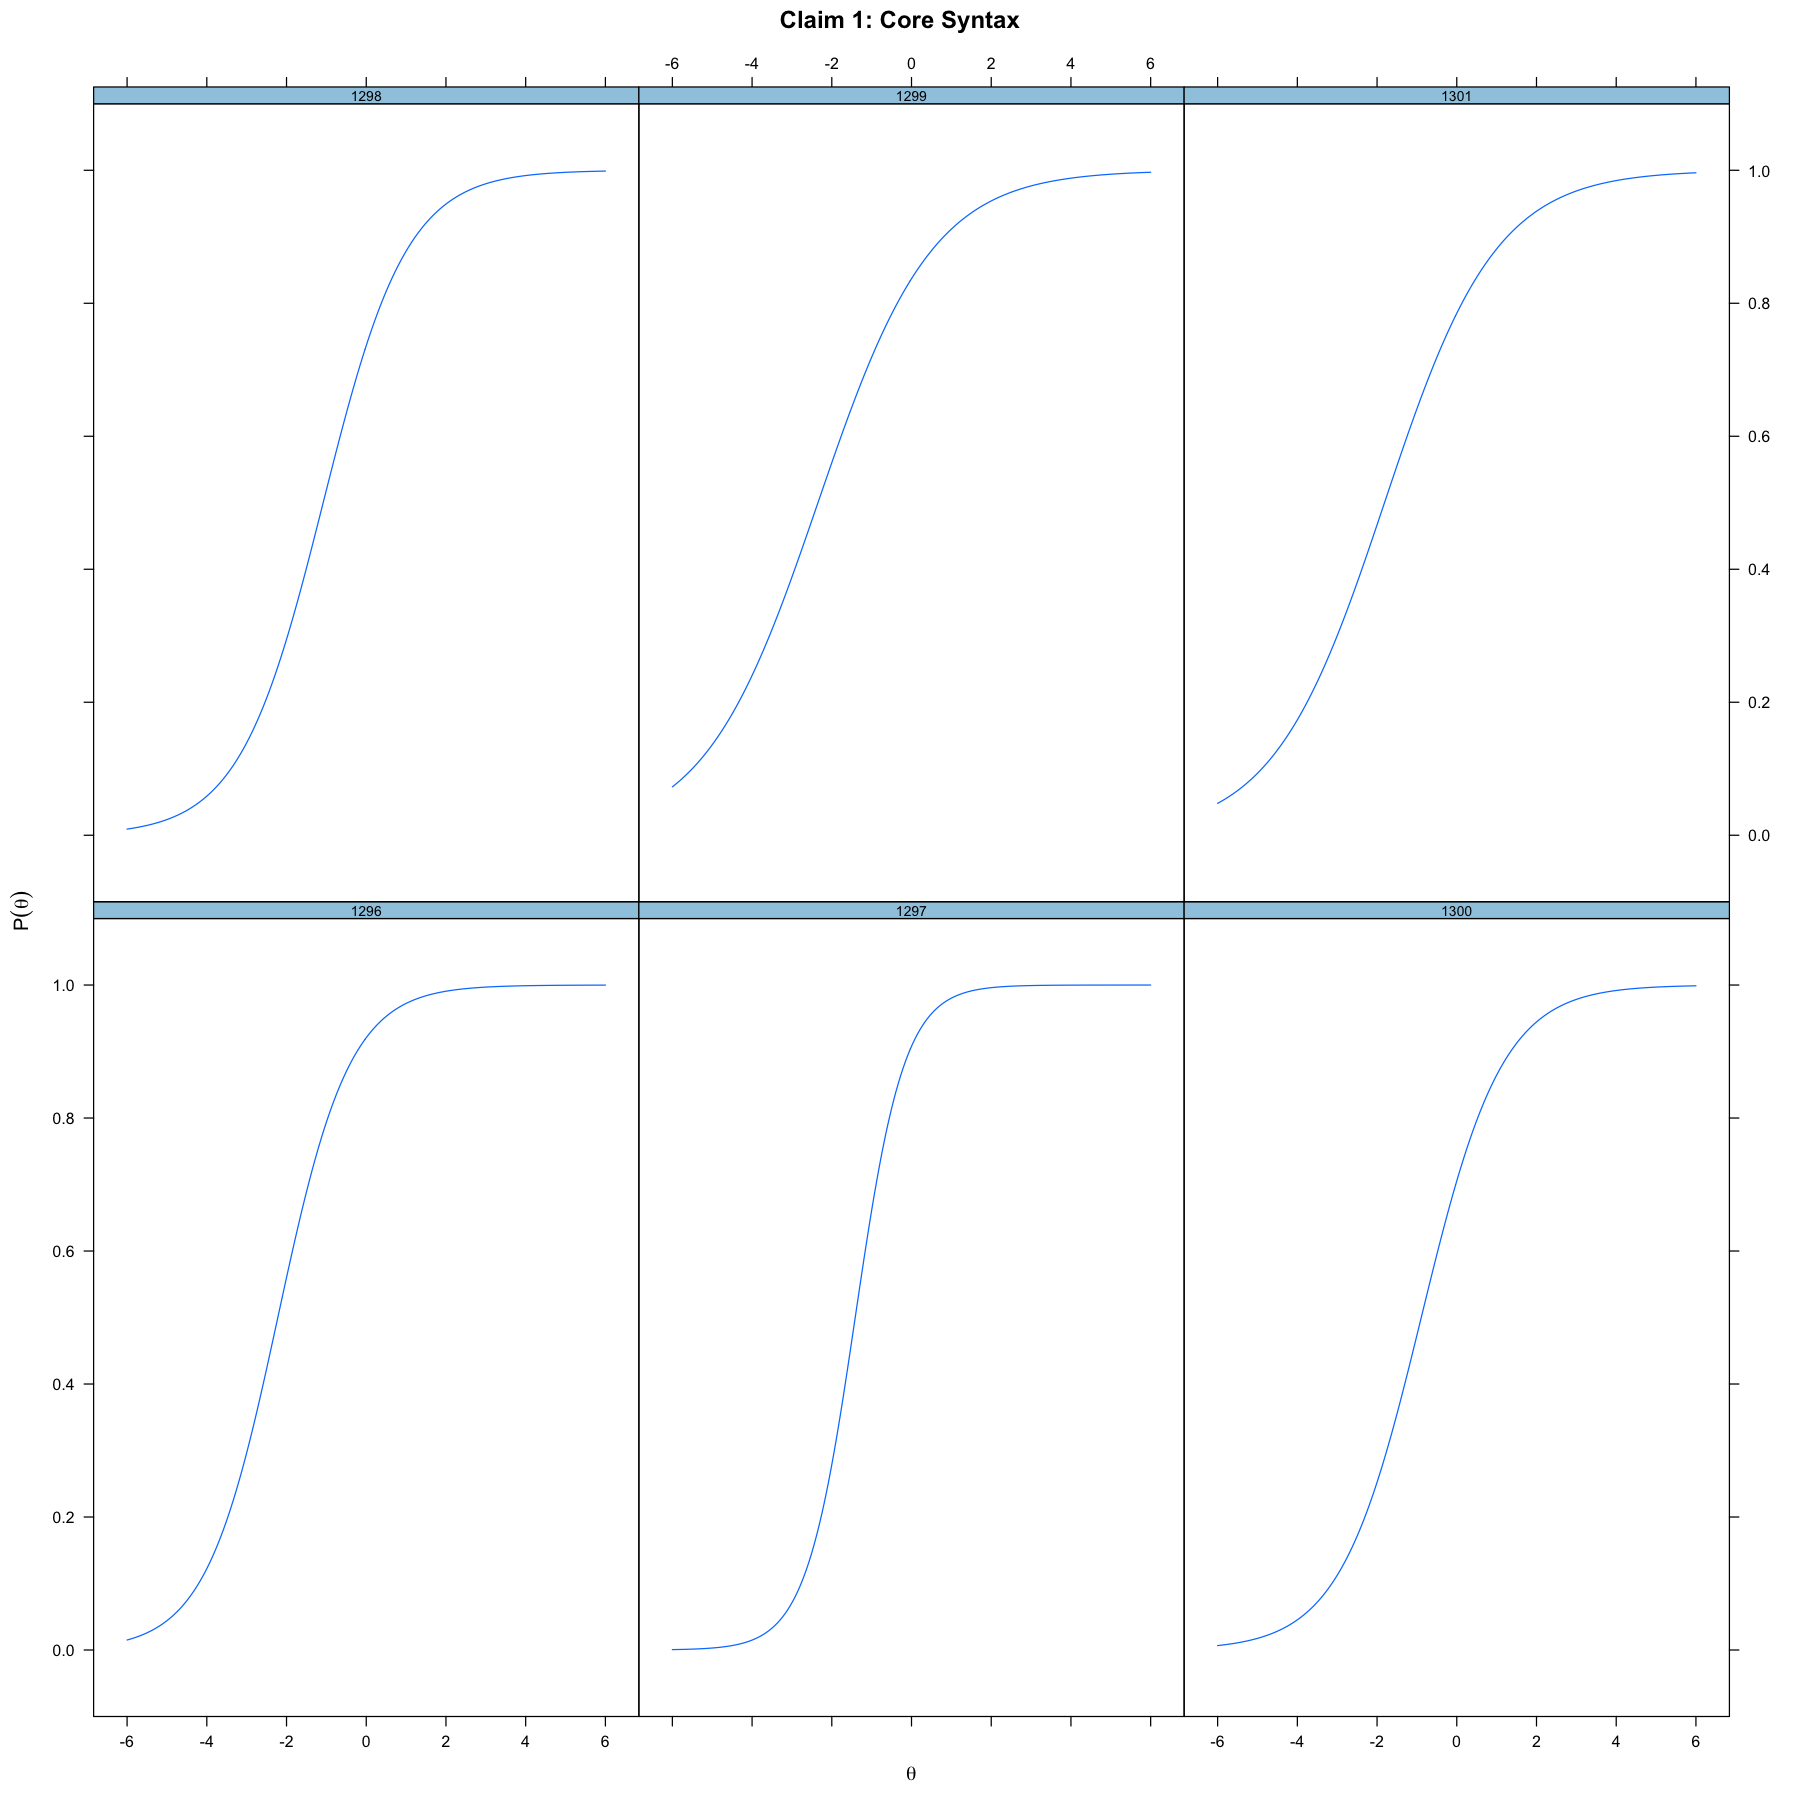

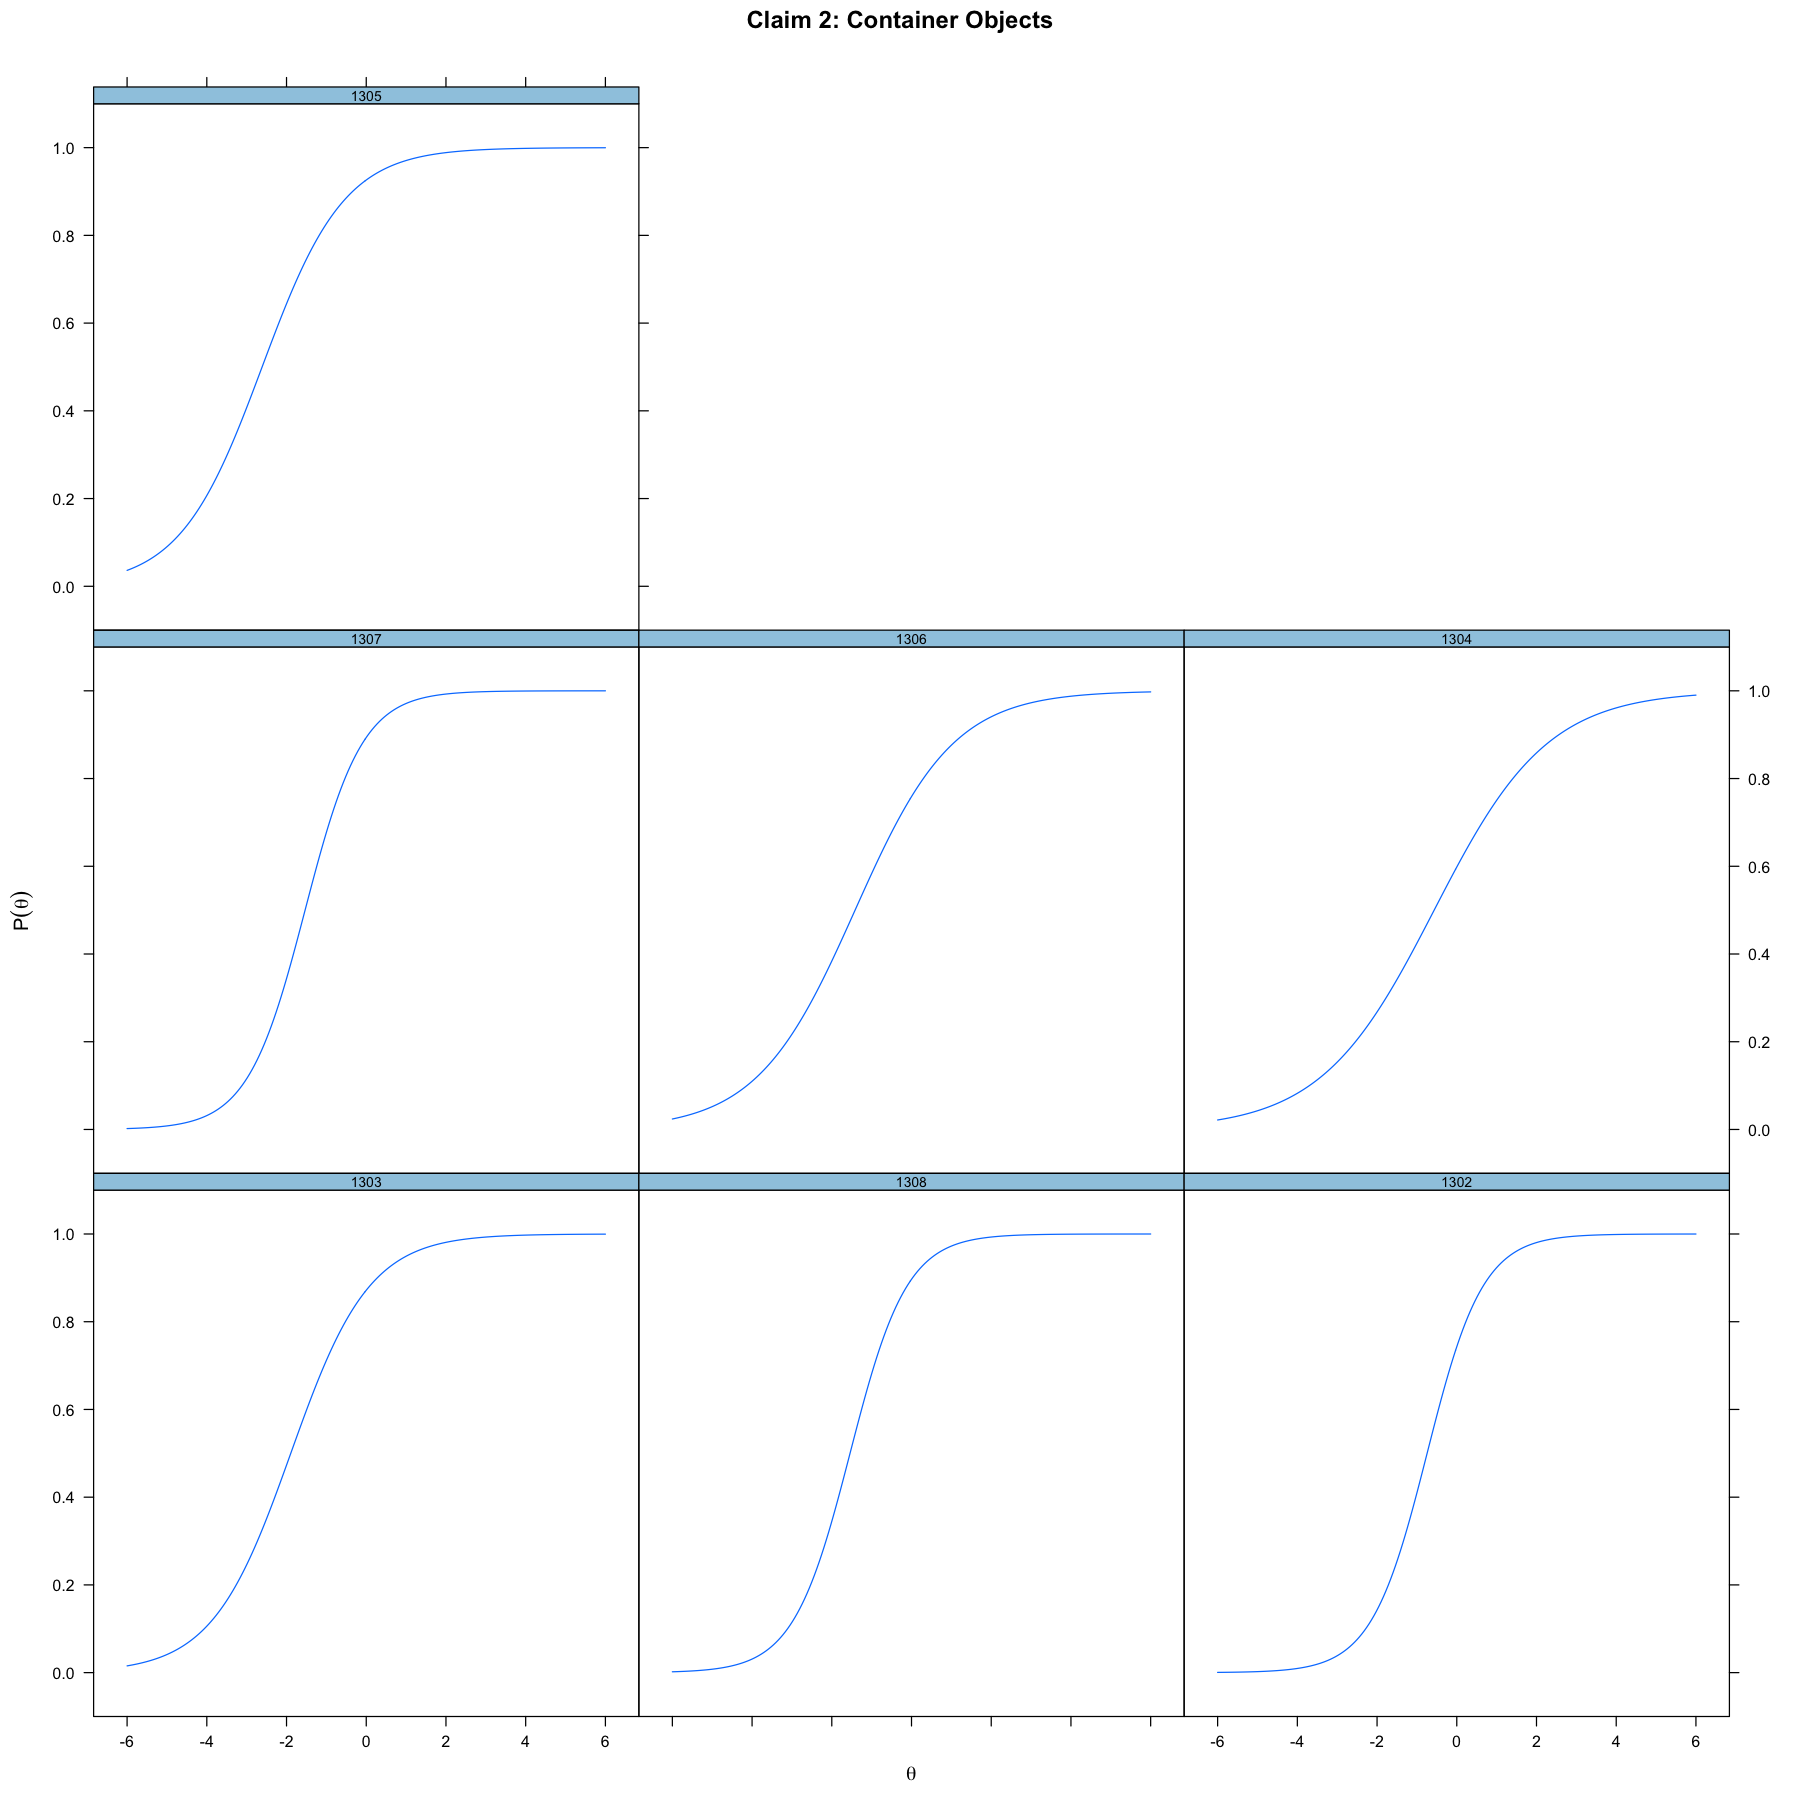

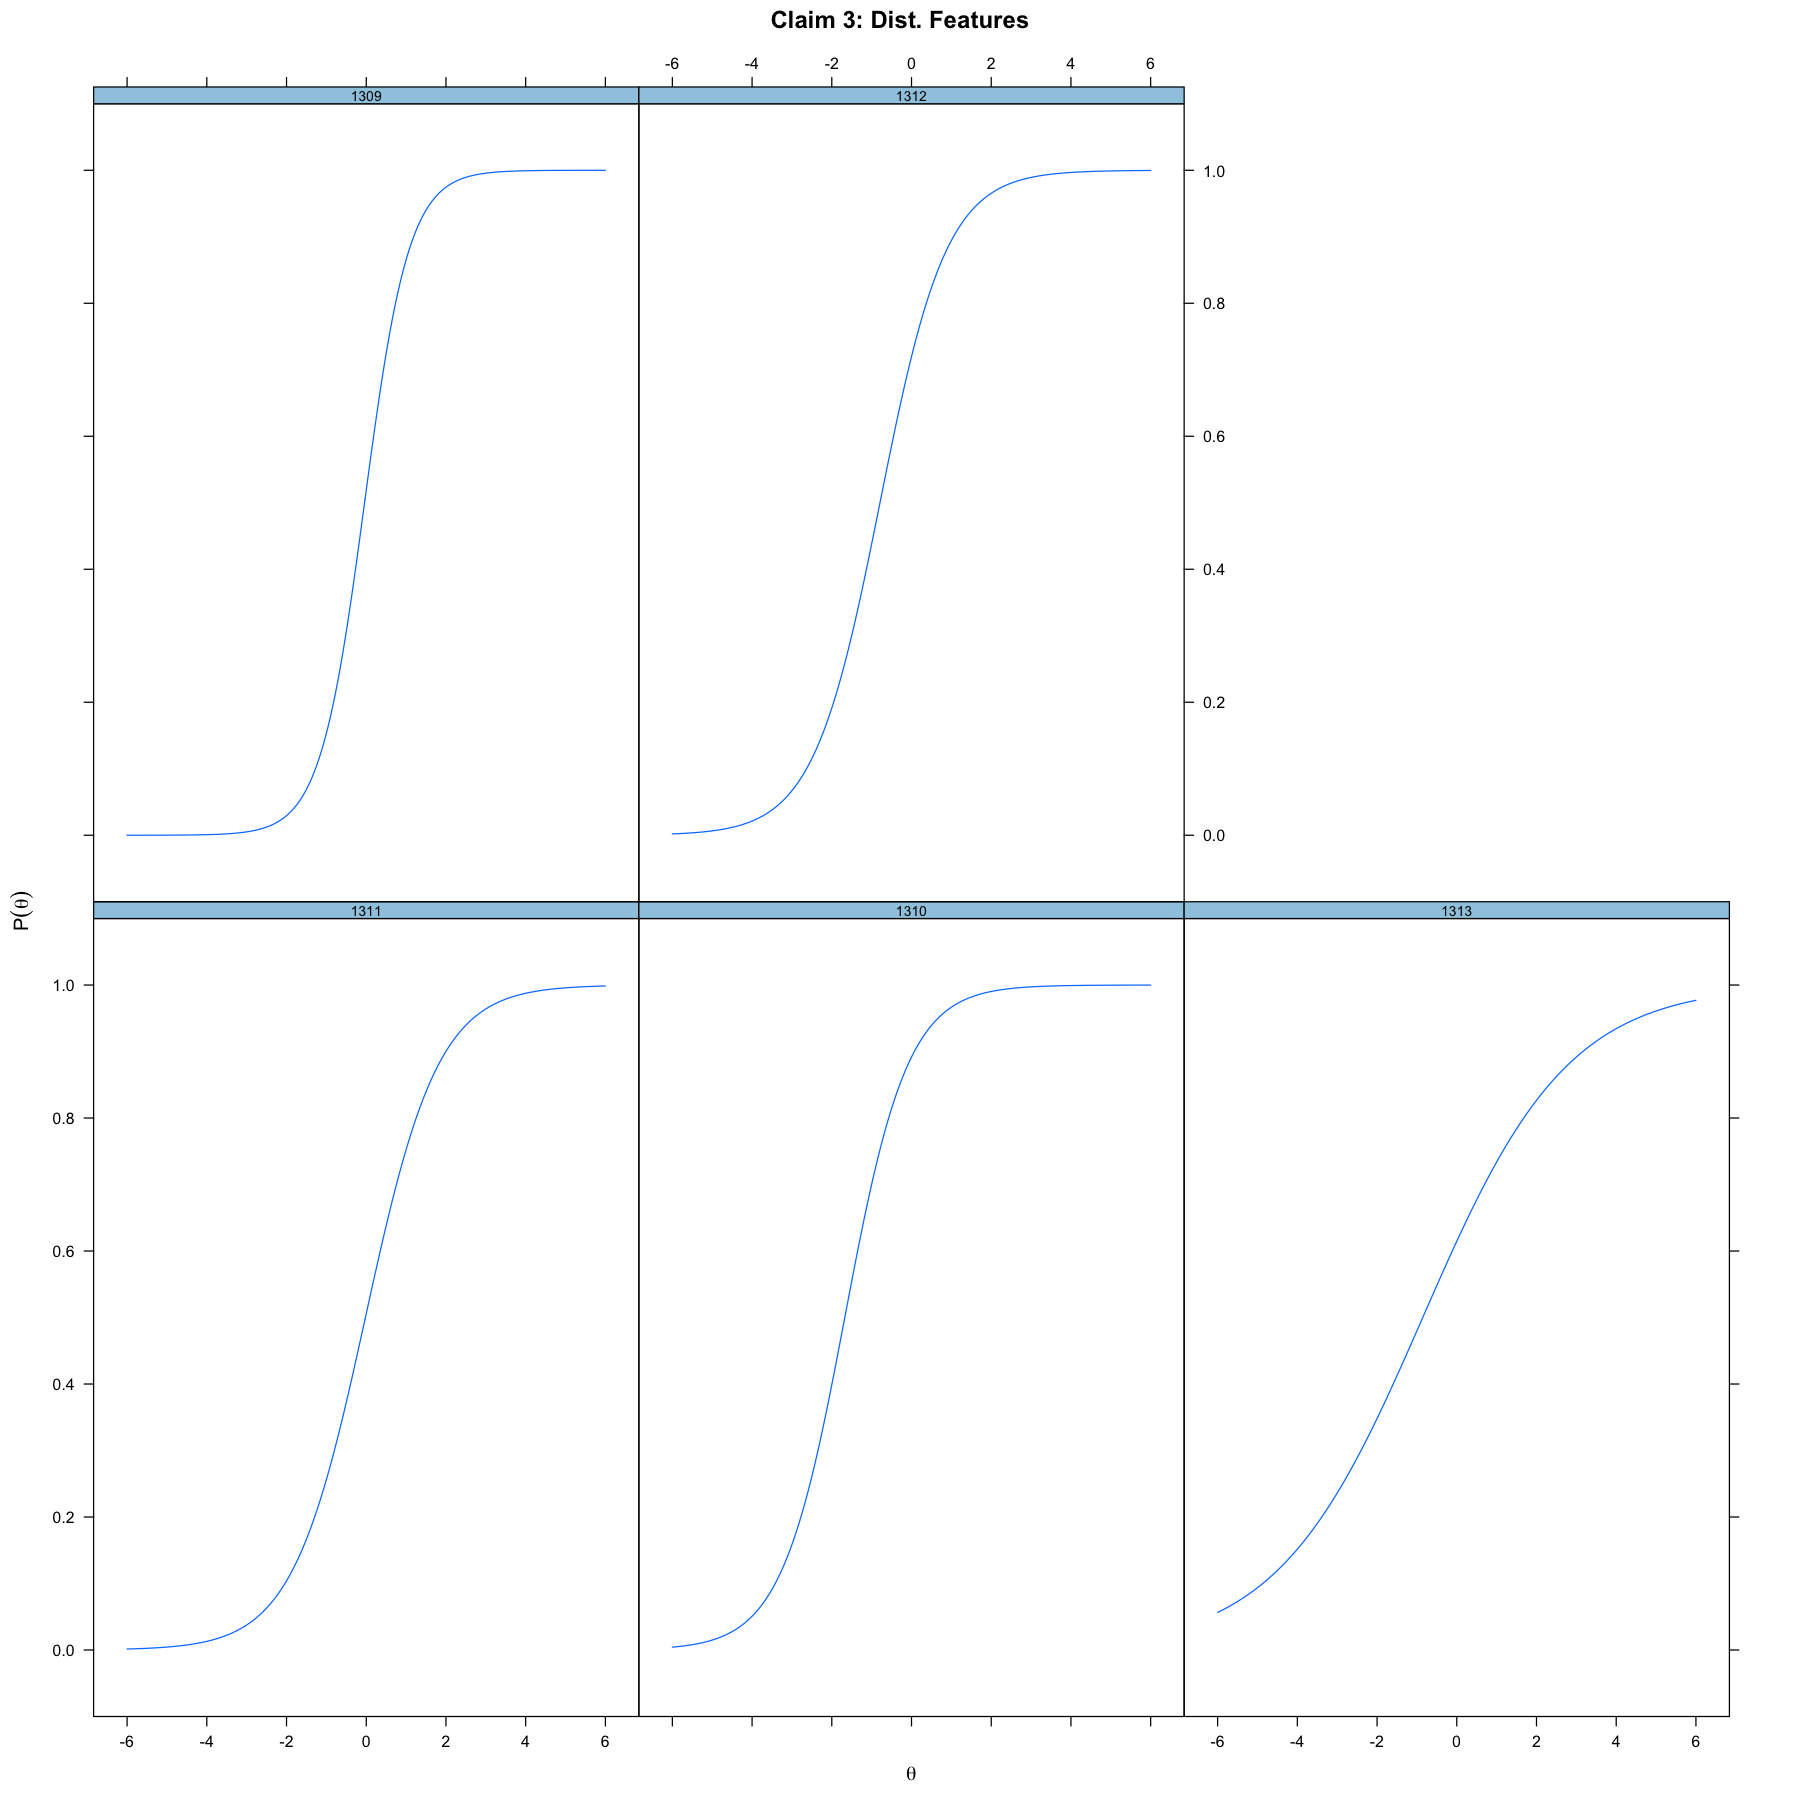

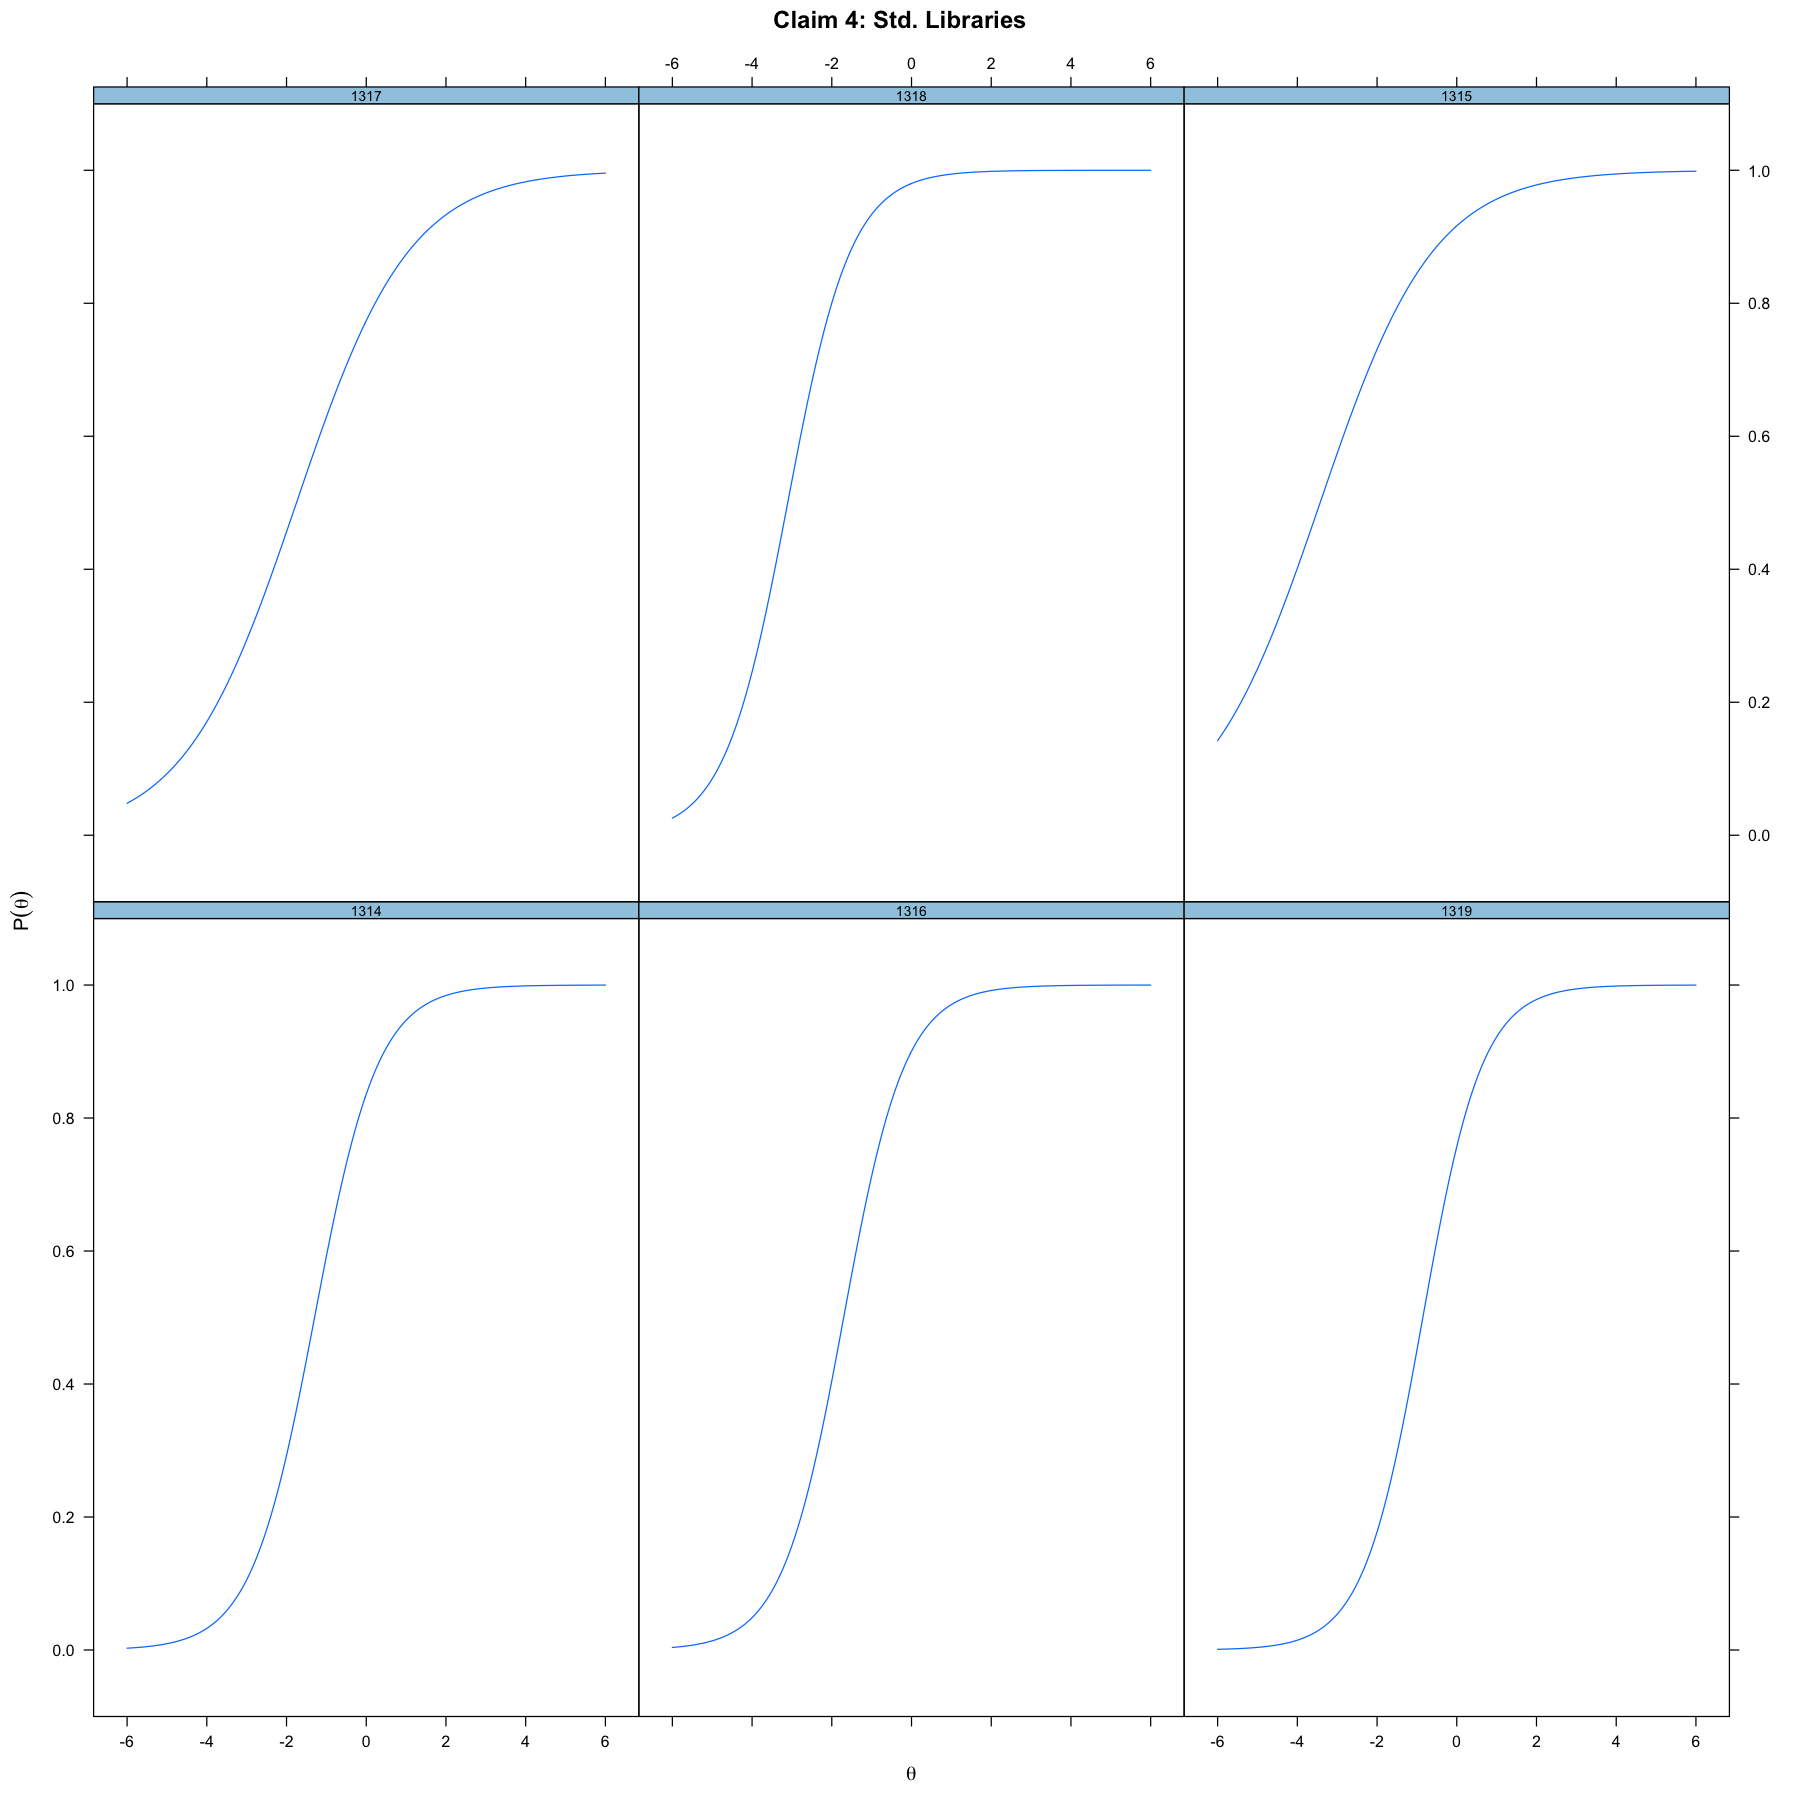

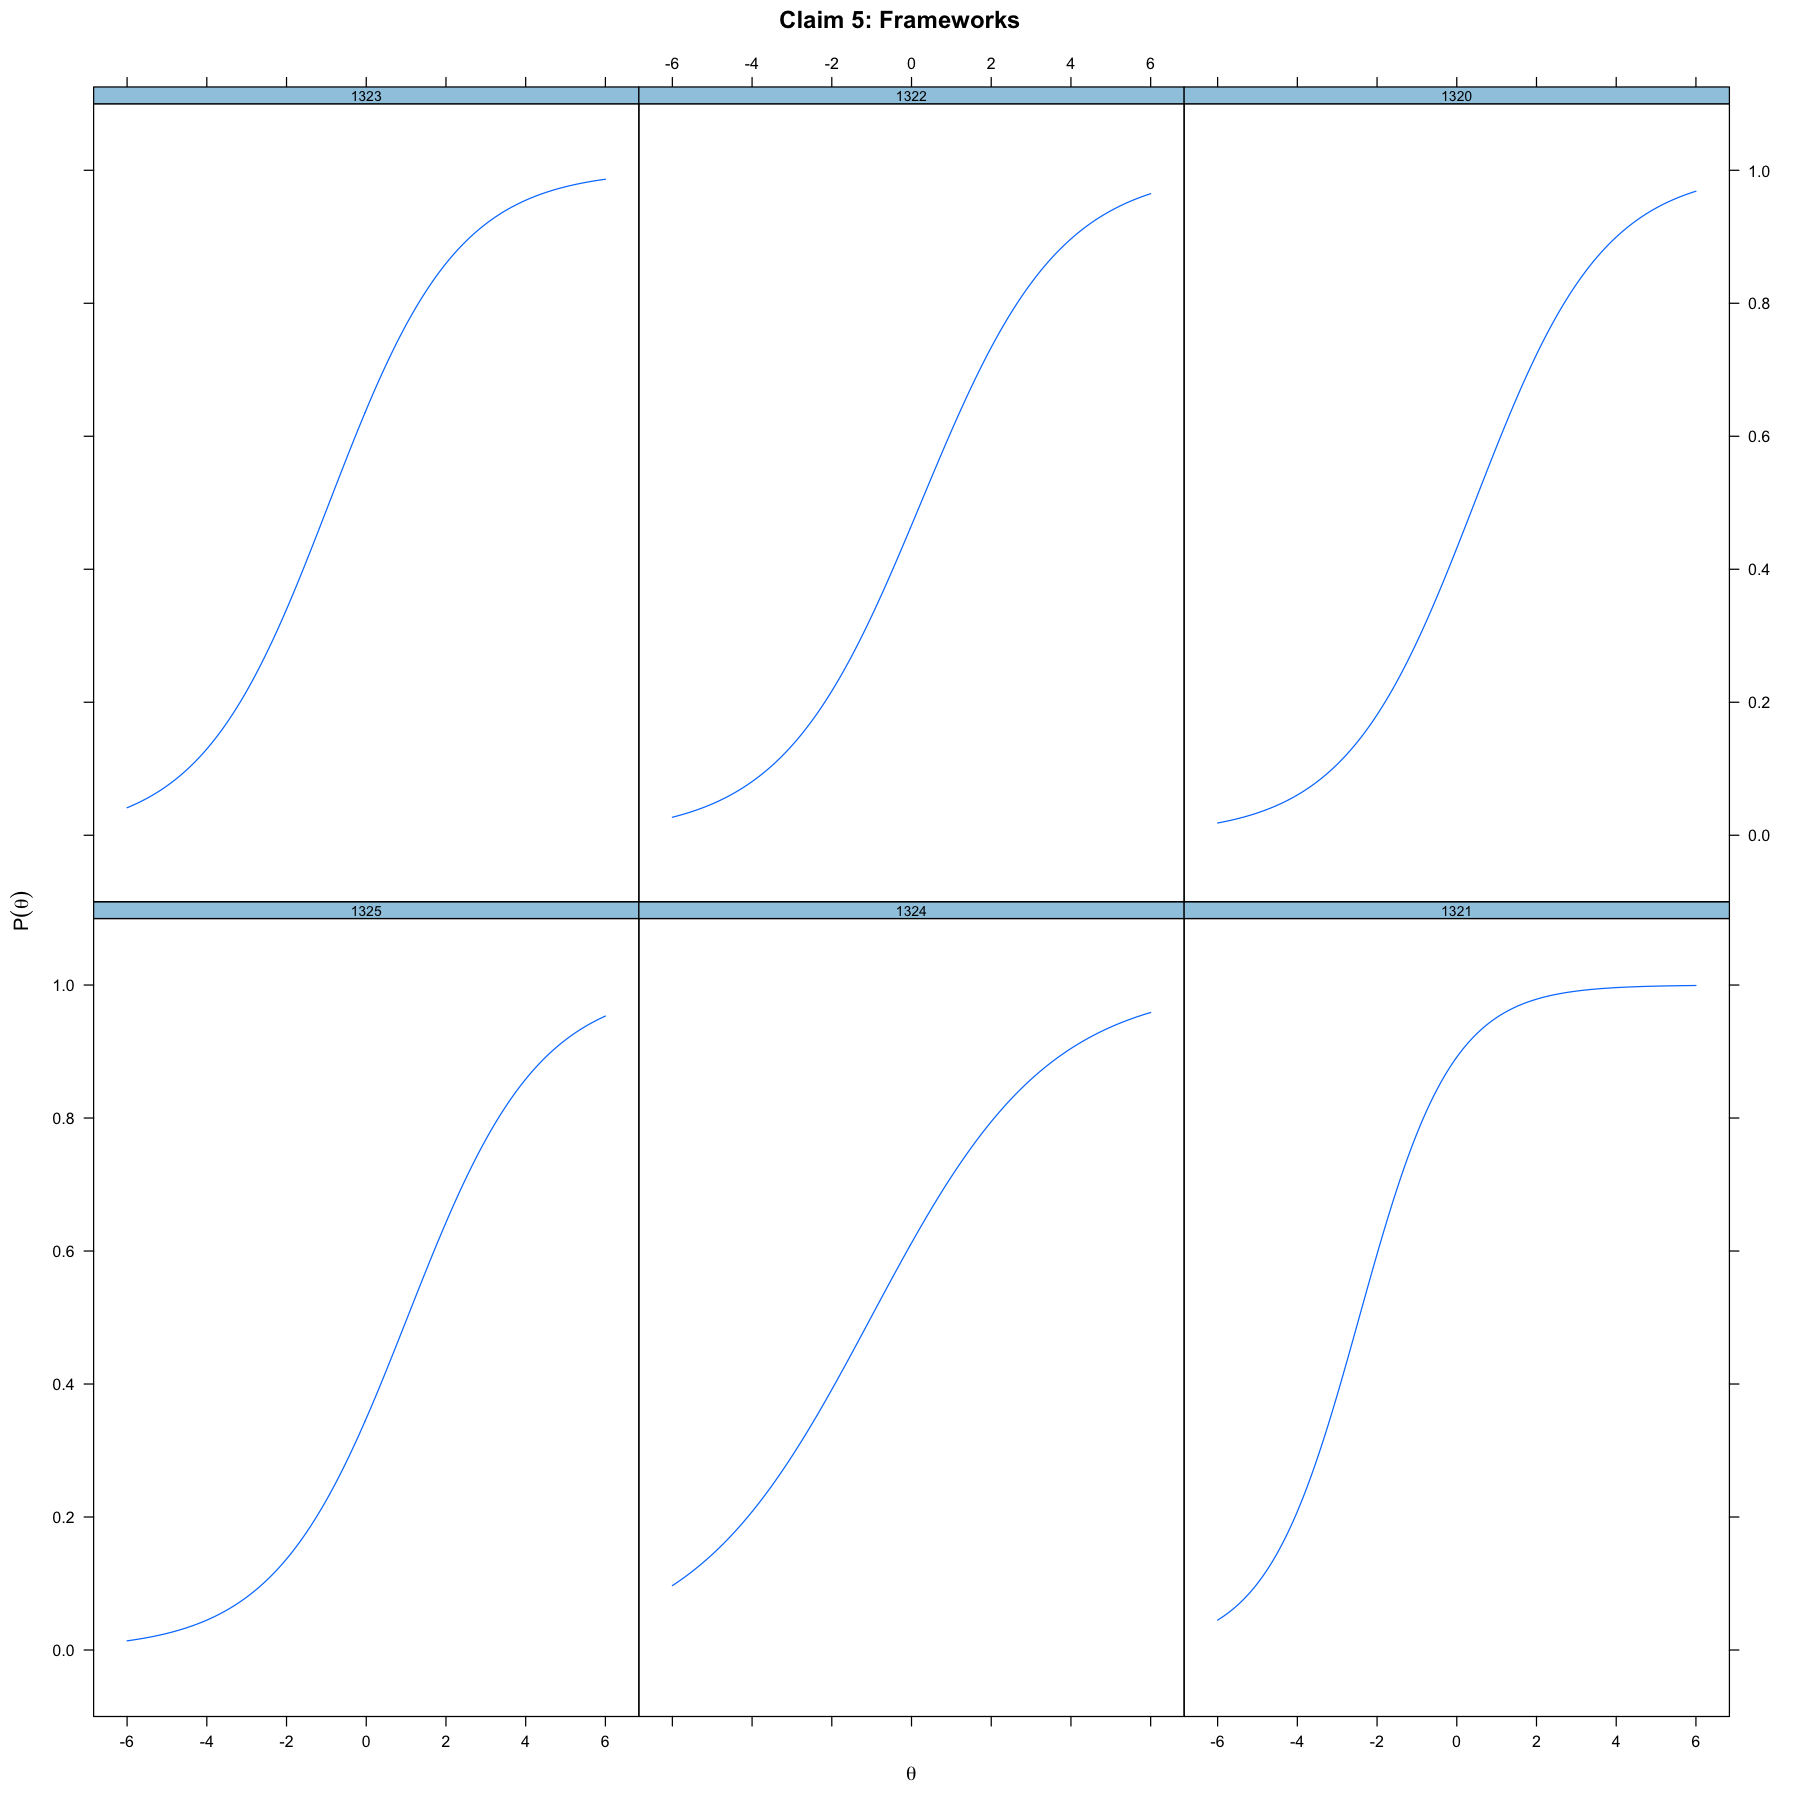

In [92]:

#plot(mod1_unidim, type = "trace",facet_items = F)

plot(mod1_unidim, type = "trace", which.items = which(df_blueprint$claim == "Claim 1"), facet_items = T, main = "Claim 1: Core Syntax")

plot(mod1_unidim, type = "trace", which.items = which(df_blueprint$claim == "Claim 2"), facet_items = T, main = "Claim 2: Container Objects")

plot(mod1_unidim, type = "trace", which.items = which(df_blueprint$claim == "Claim 3"), facet_items = T, main = "Claim 3: Dist. Features")

plot(mod1_unidim, type = "trace", which.items = which(df_blueprint$claim == "Claim 4"), facet_items = T, main = "Claim 4: Std. Libraries")

plot(mod1_unidim, type = "trace", which.items = which(df_blueprint$claim == "Claim 5"), facet_items = T, main = "Claim 5: Frameworks")

# plot(mod1_unidim, type = "trace", which.items = which(df_blueprint$claim == "Claim 6"), facet_items = T, main = "Claim 6: Coding Tasks")

#### Item Information Curves by Claims

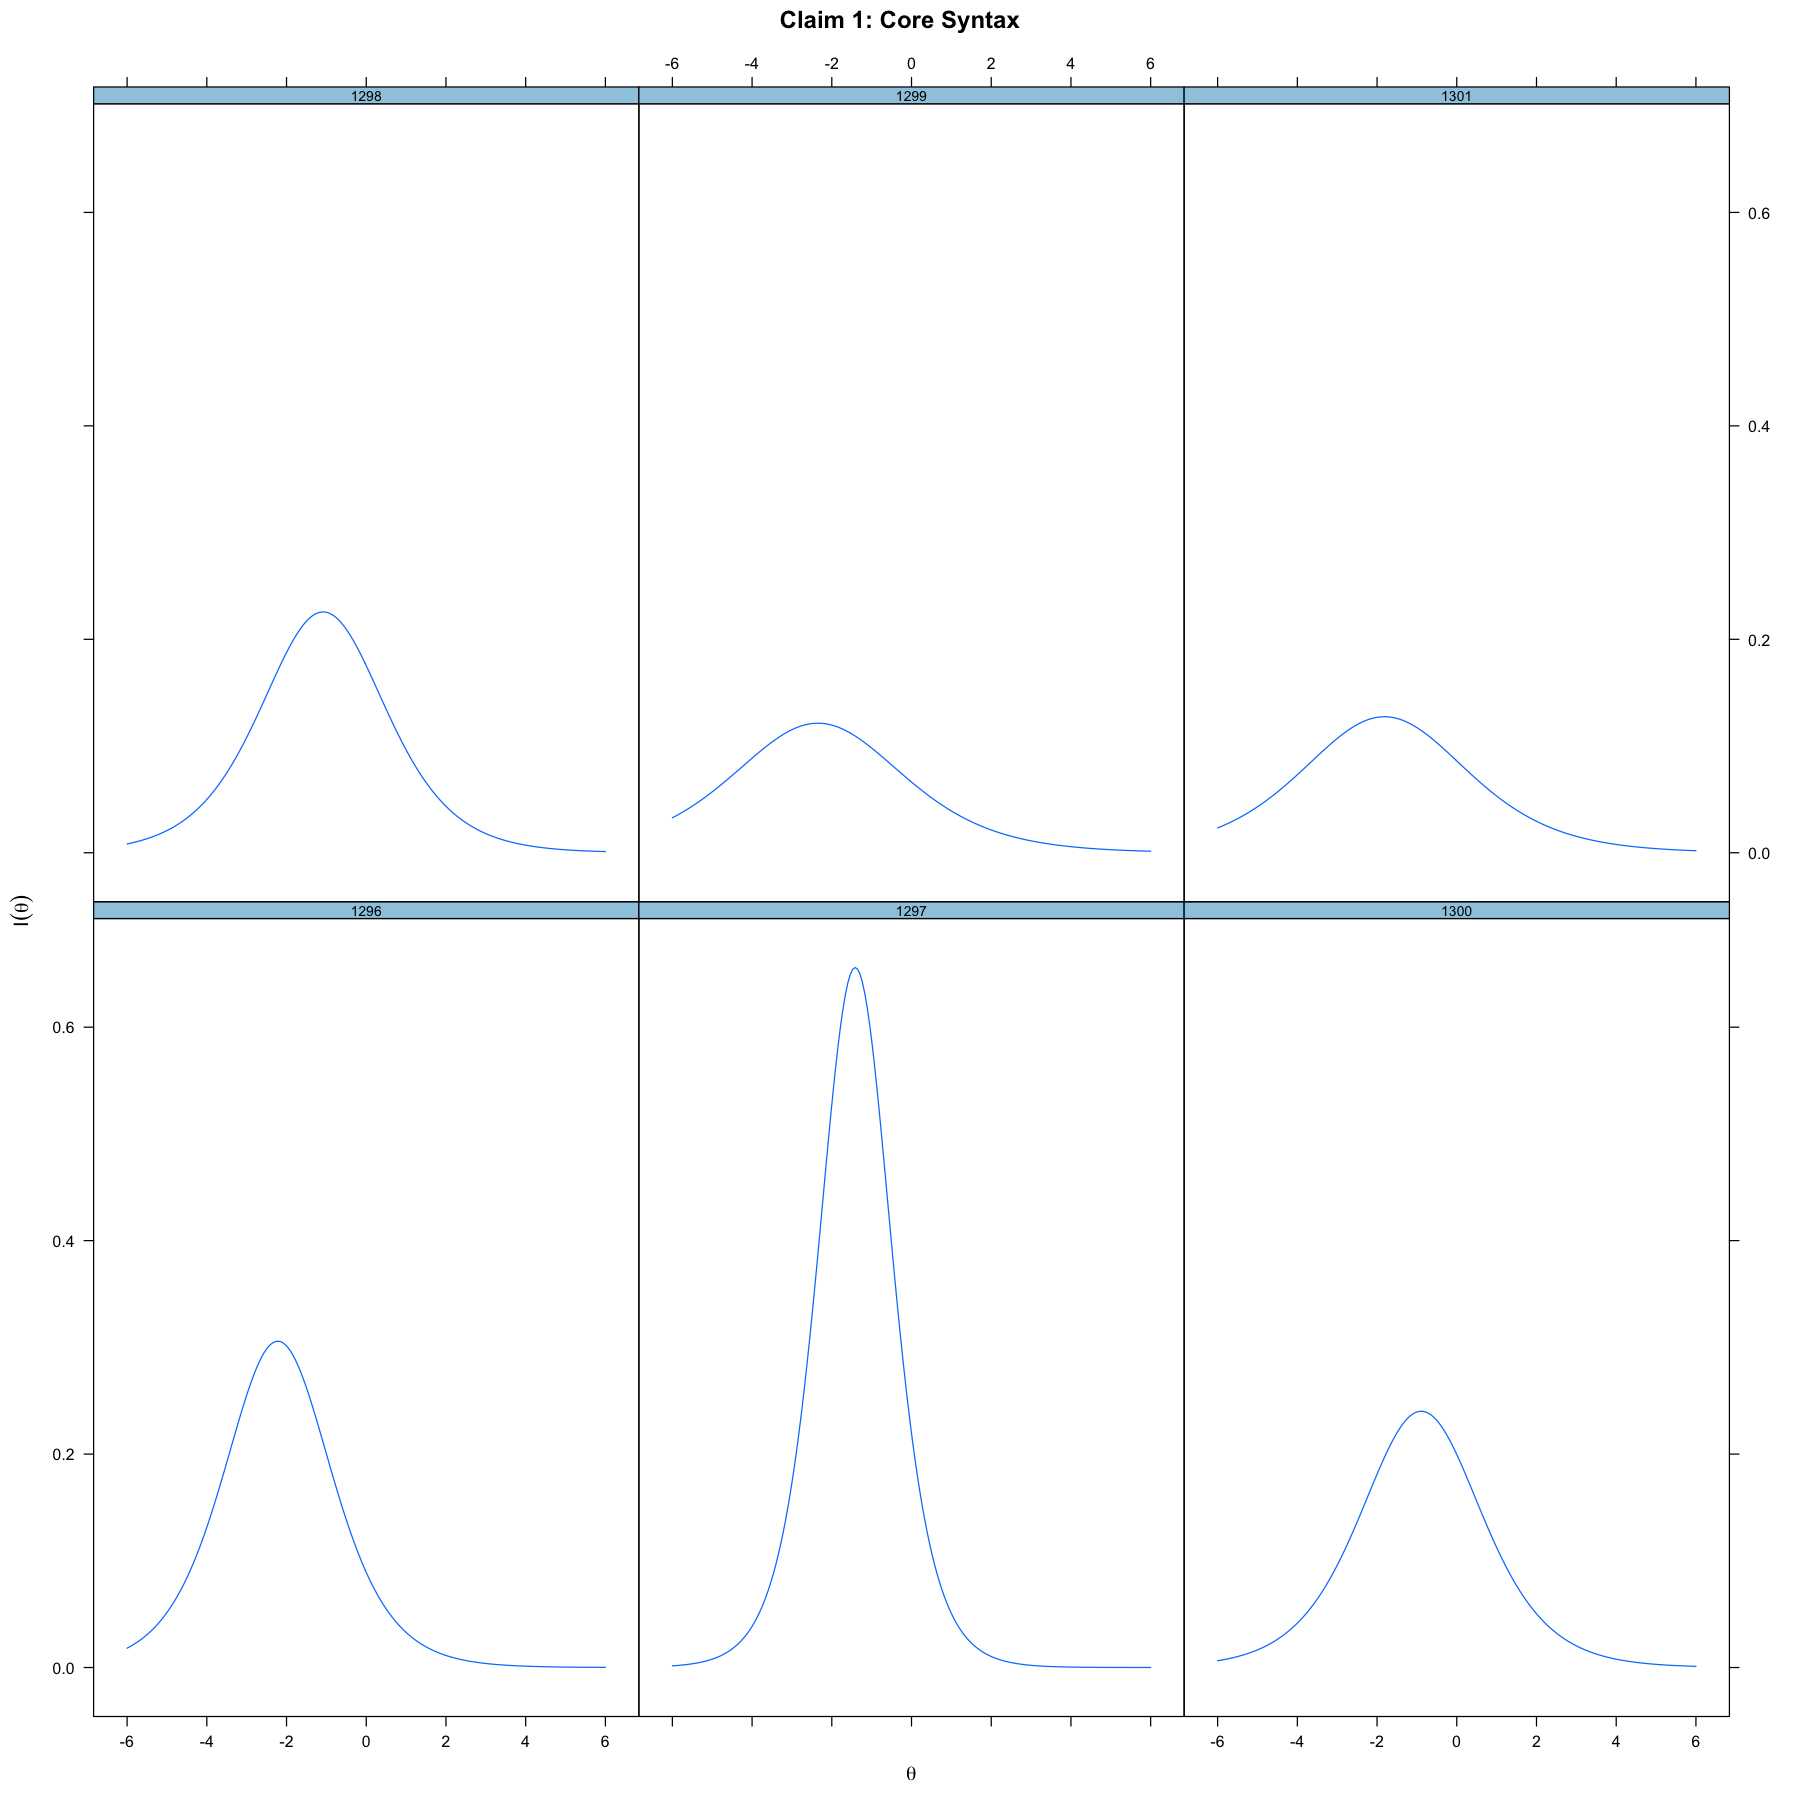

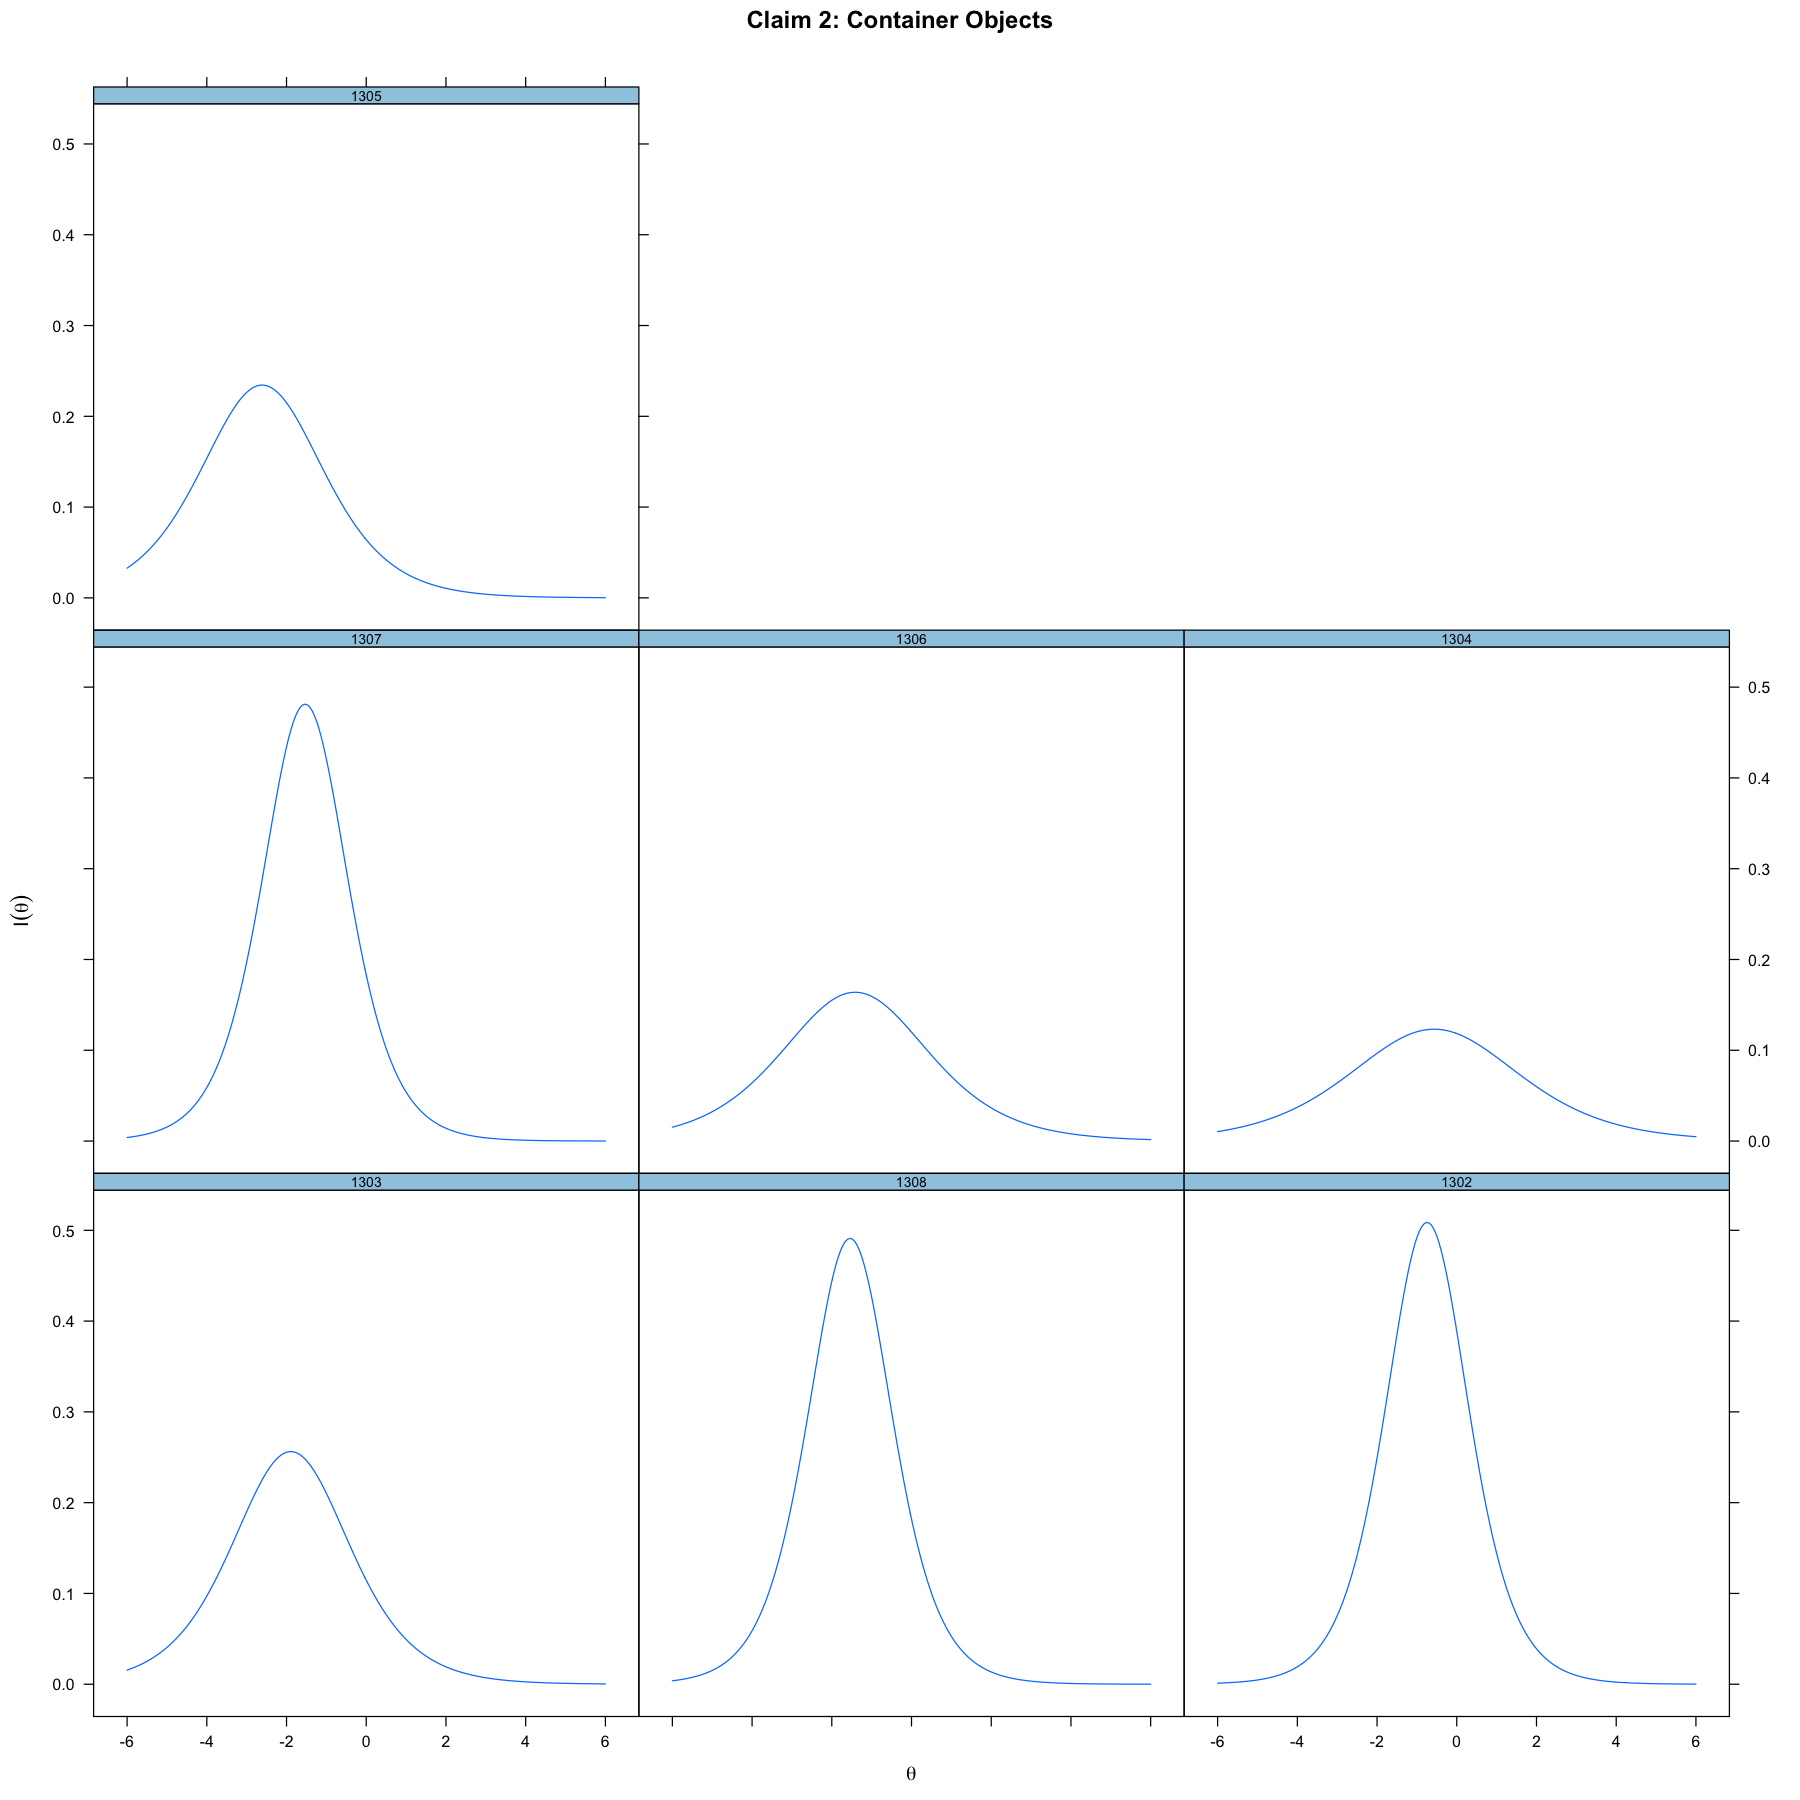

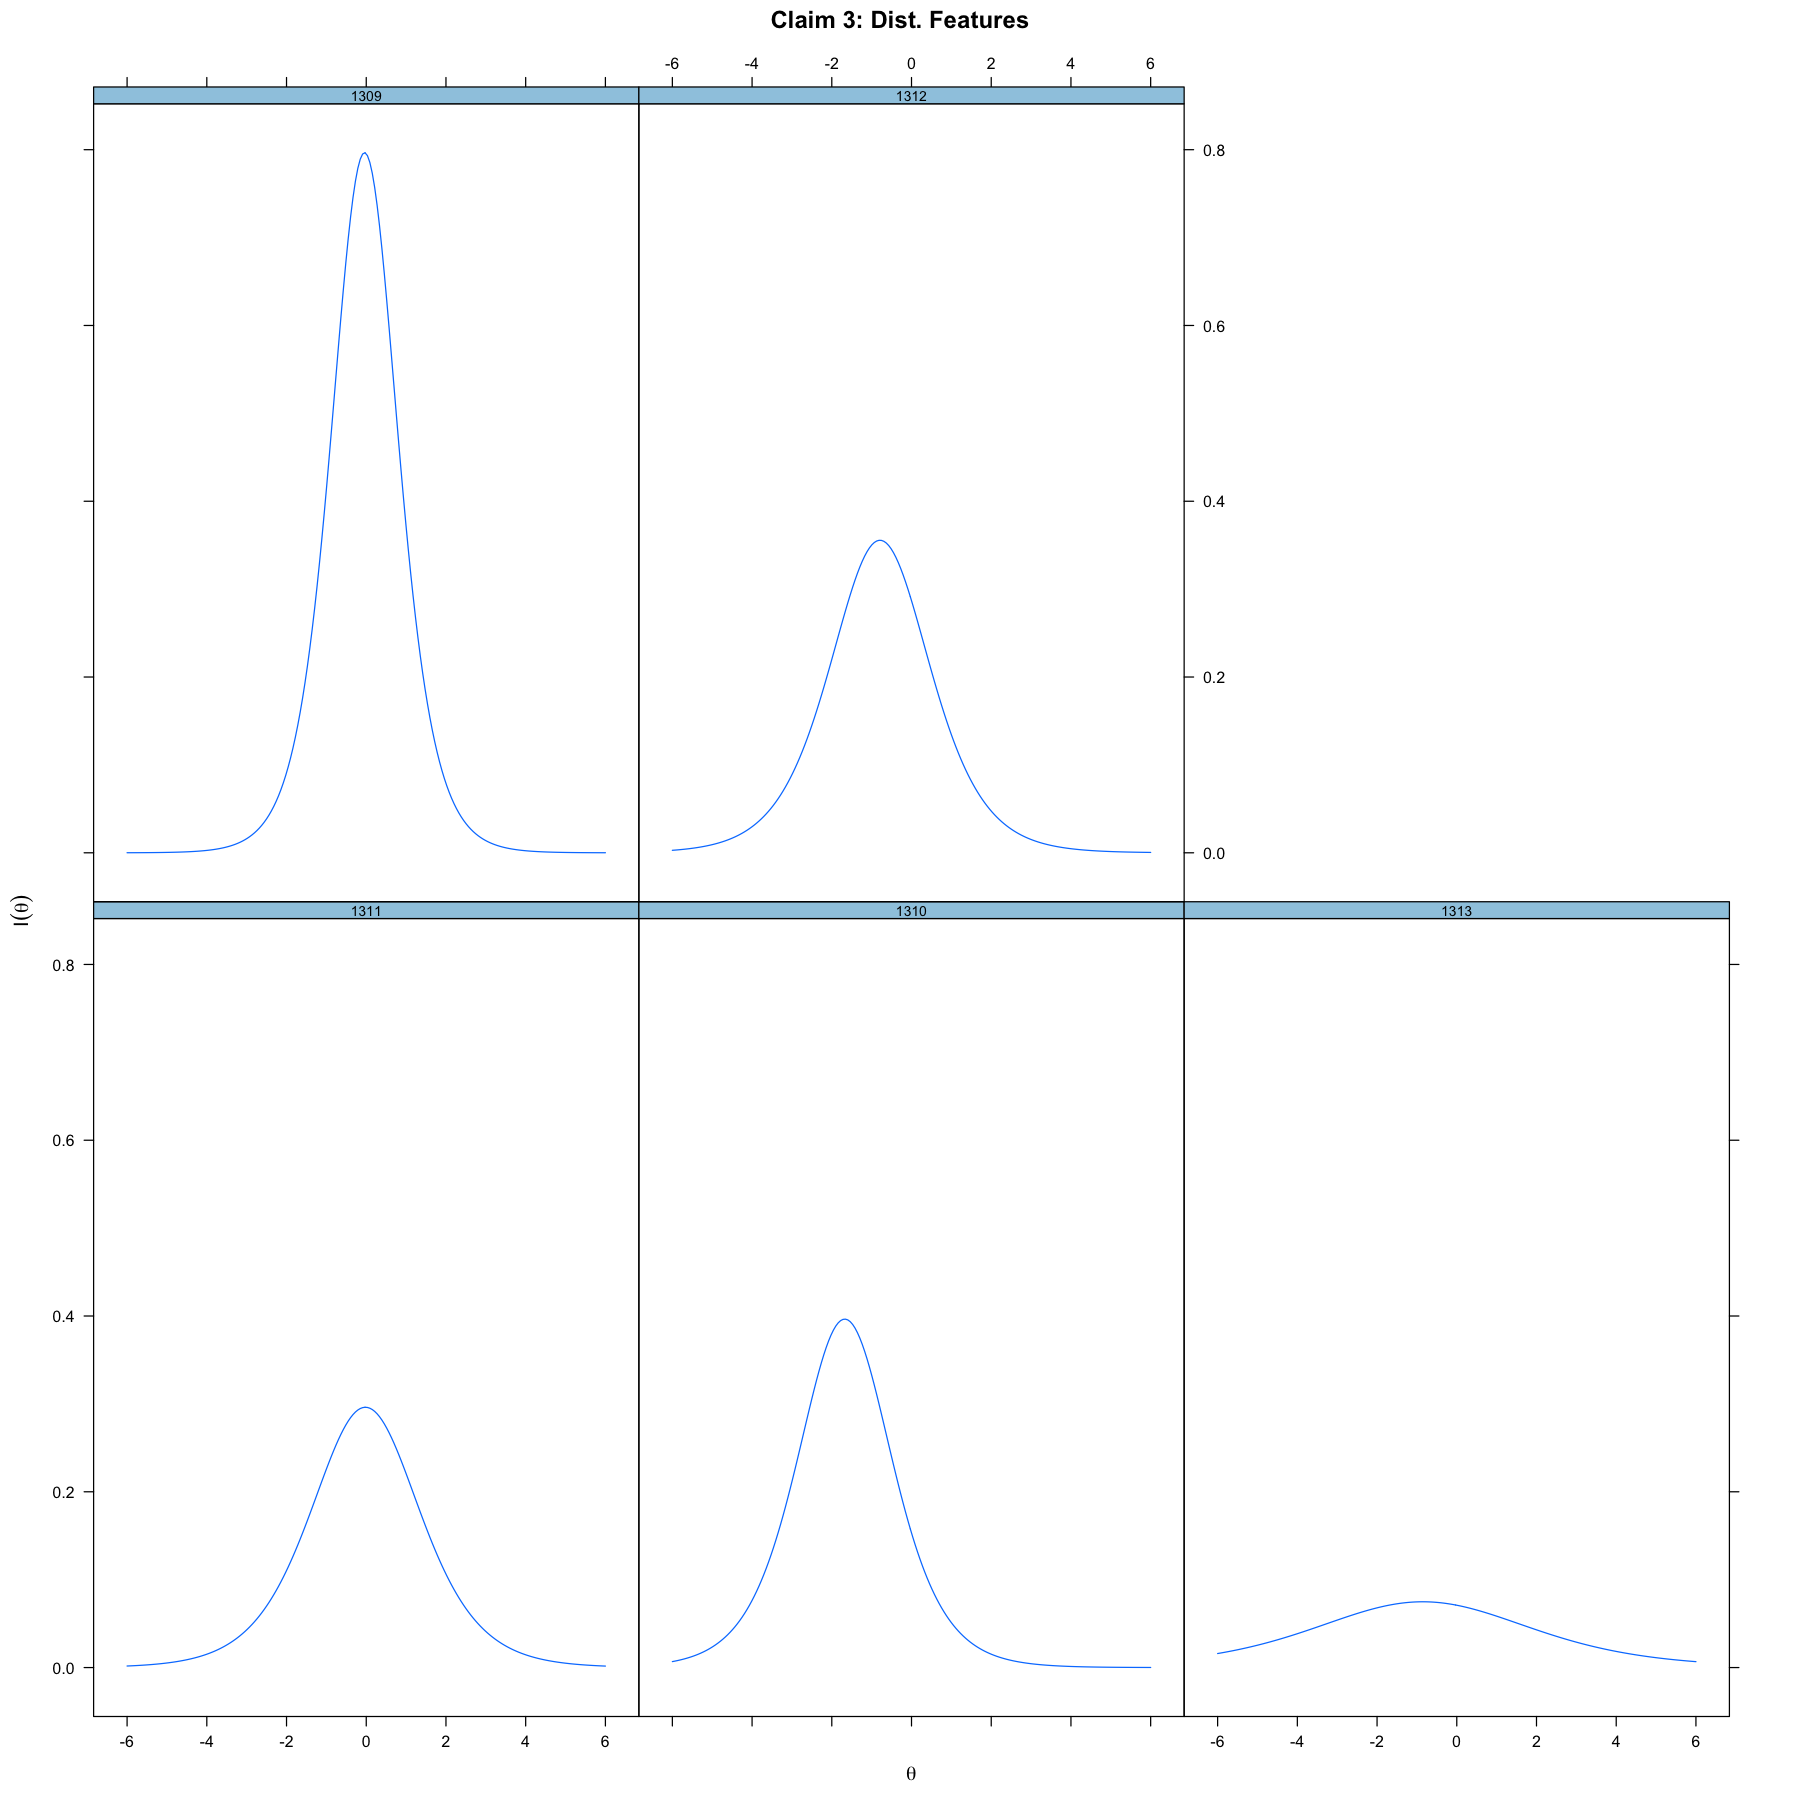

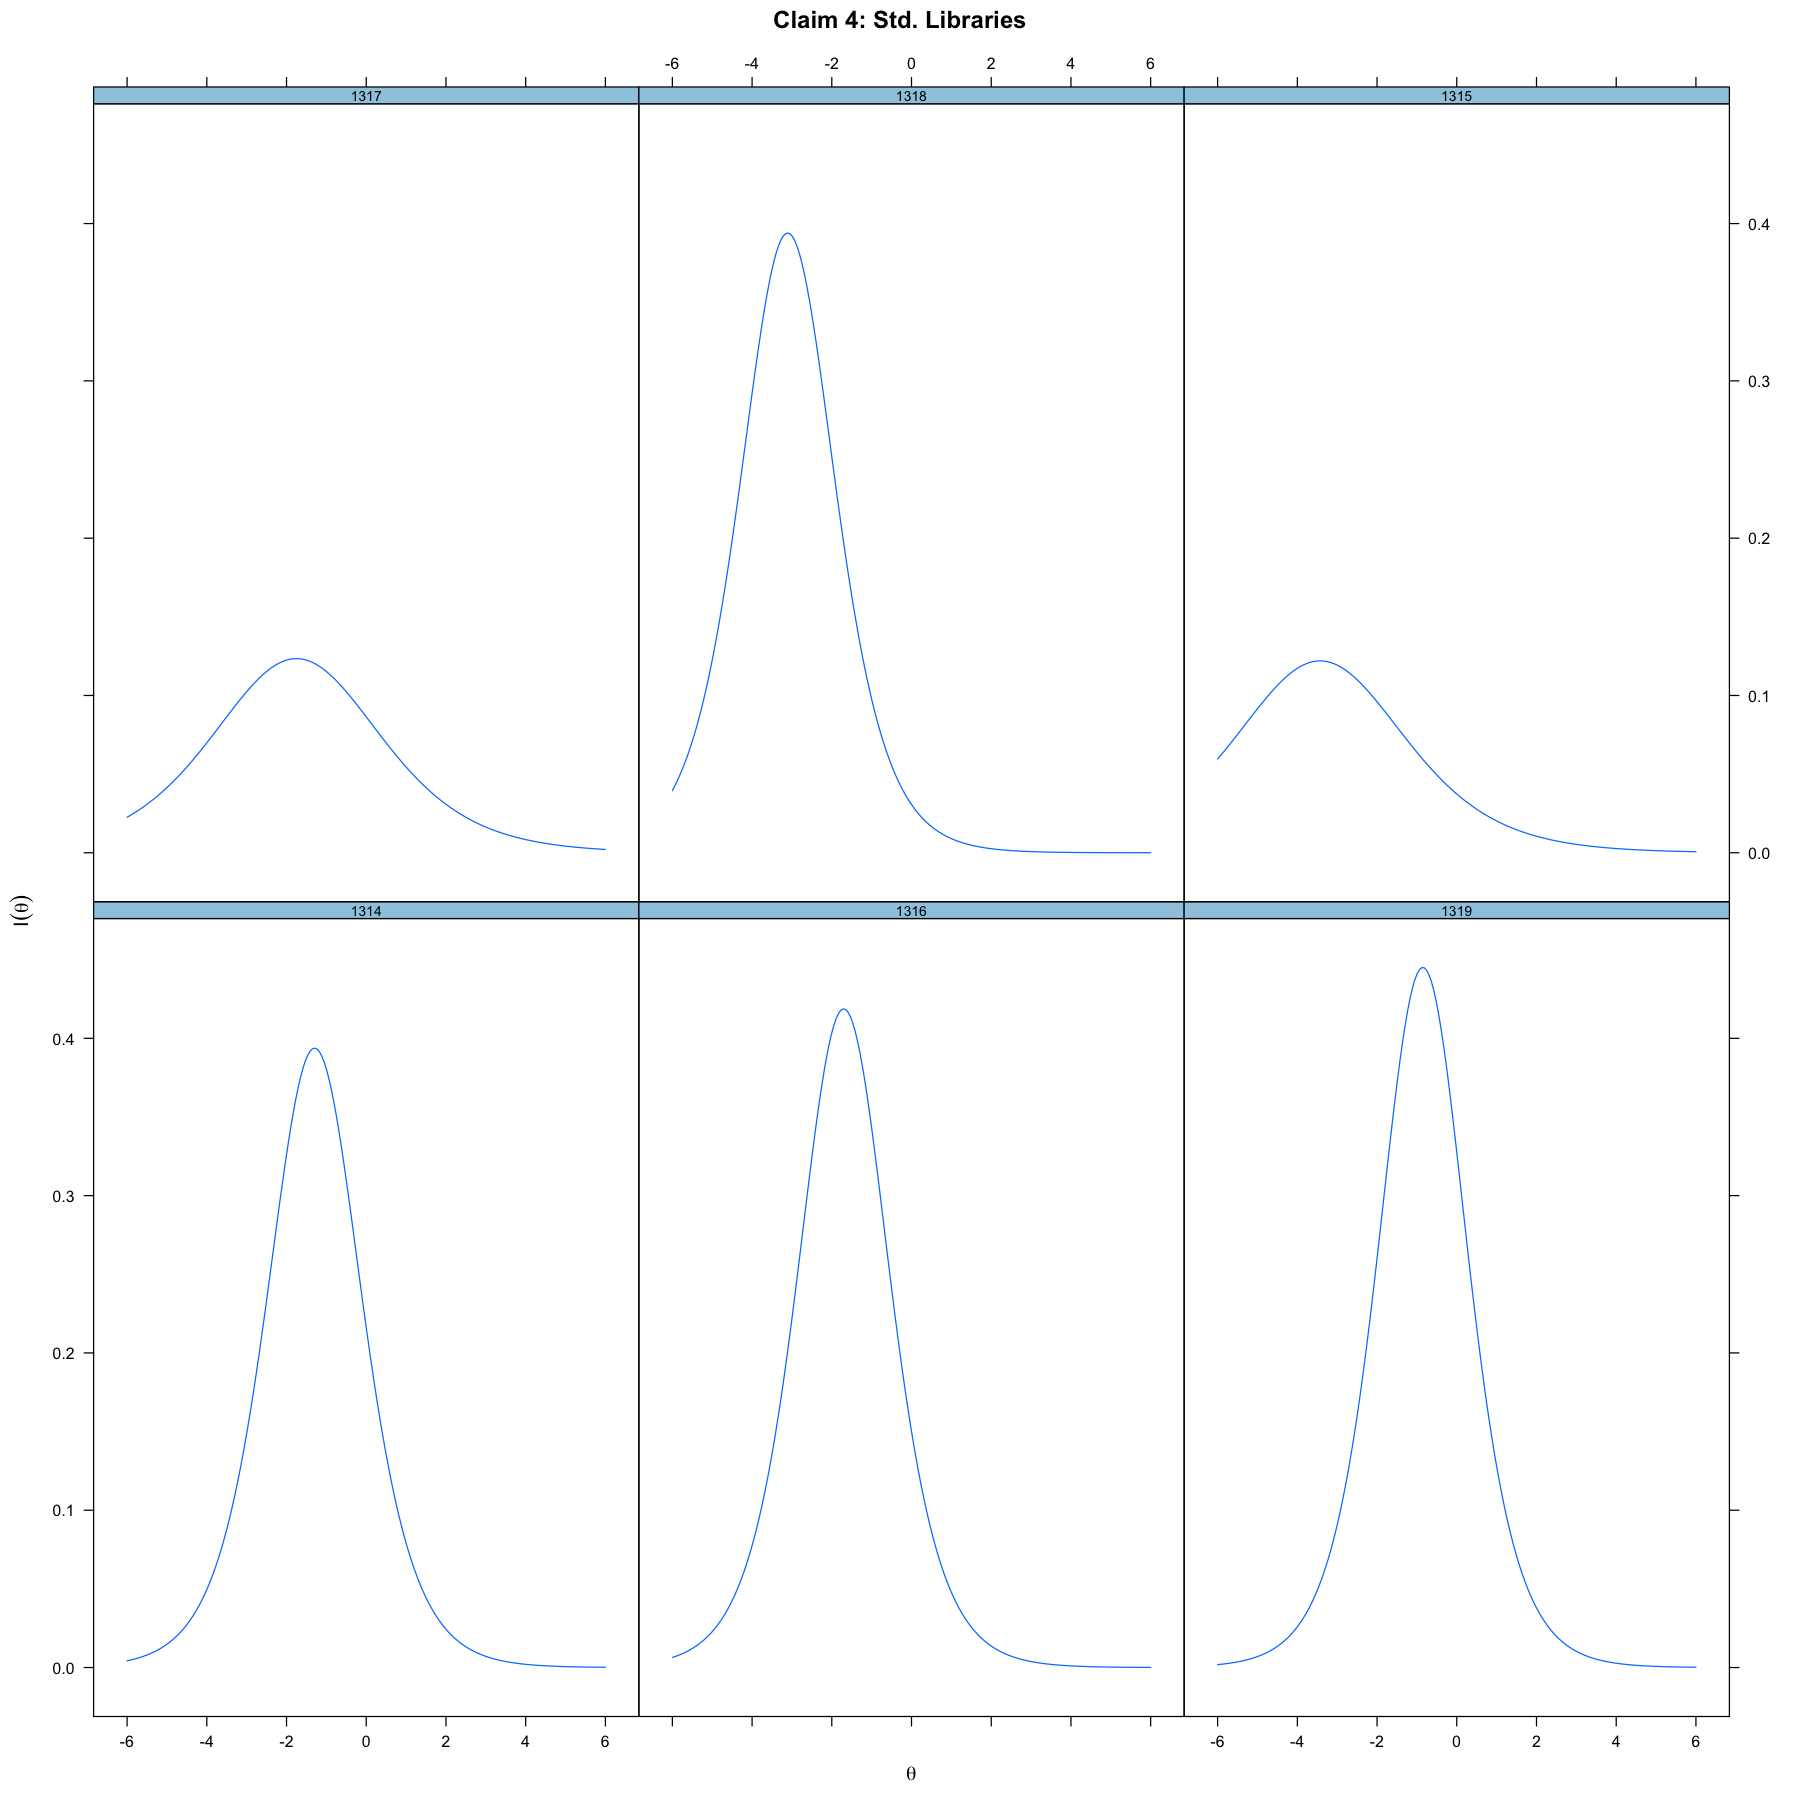

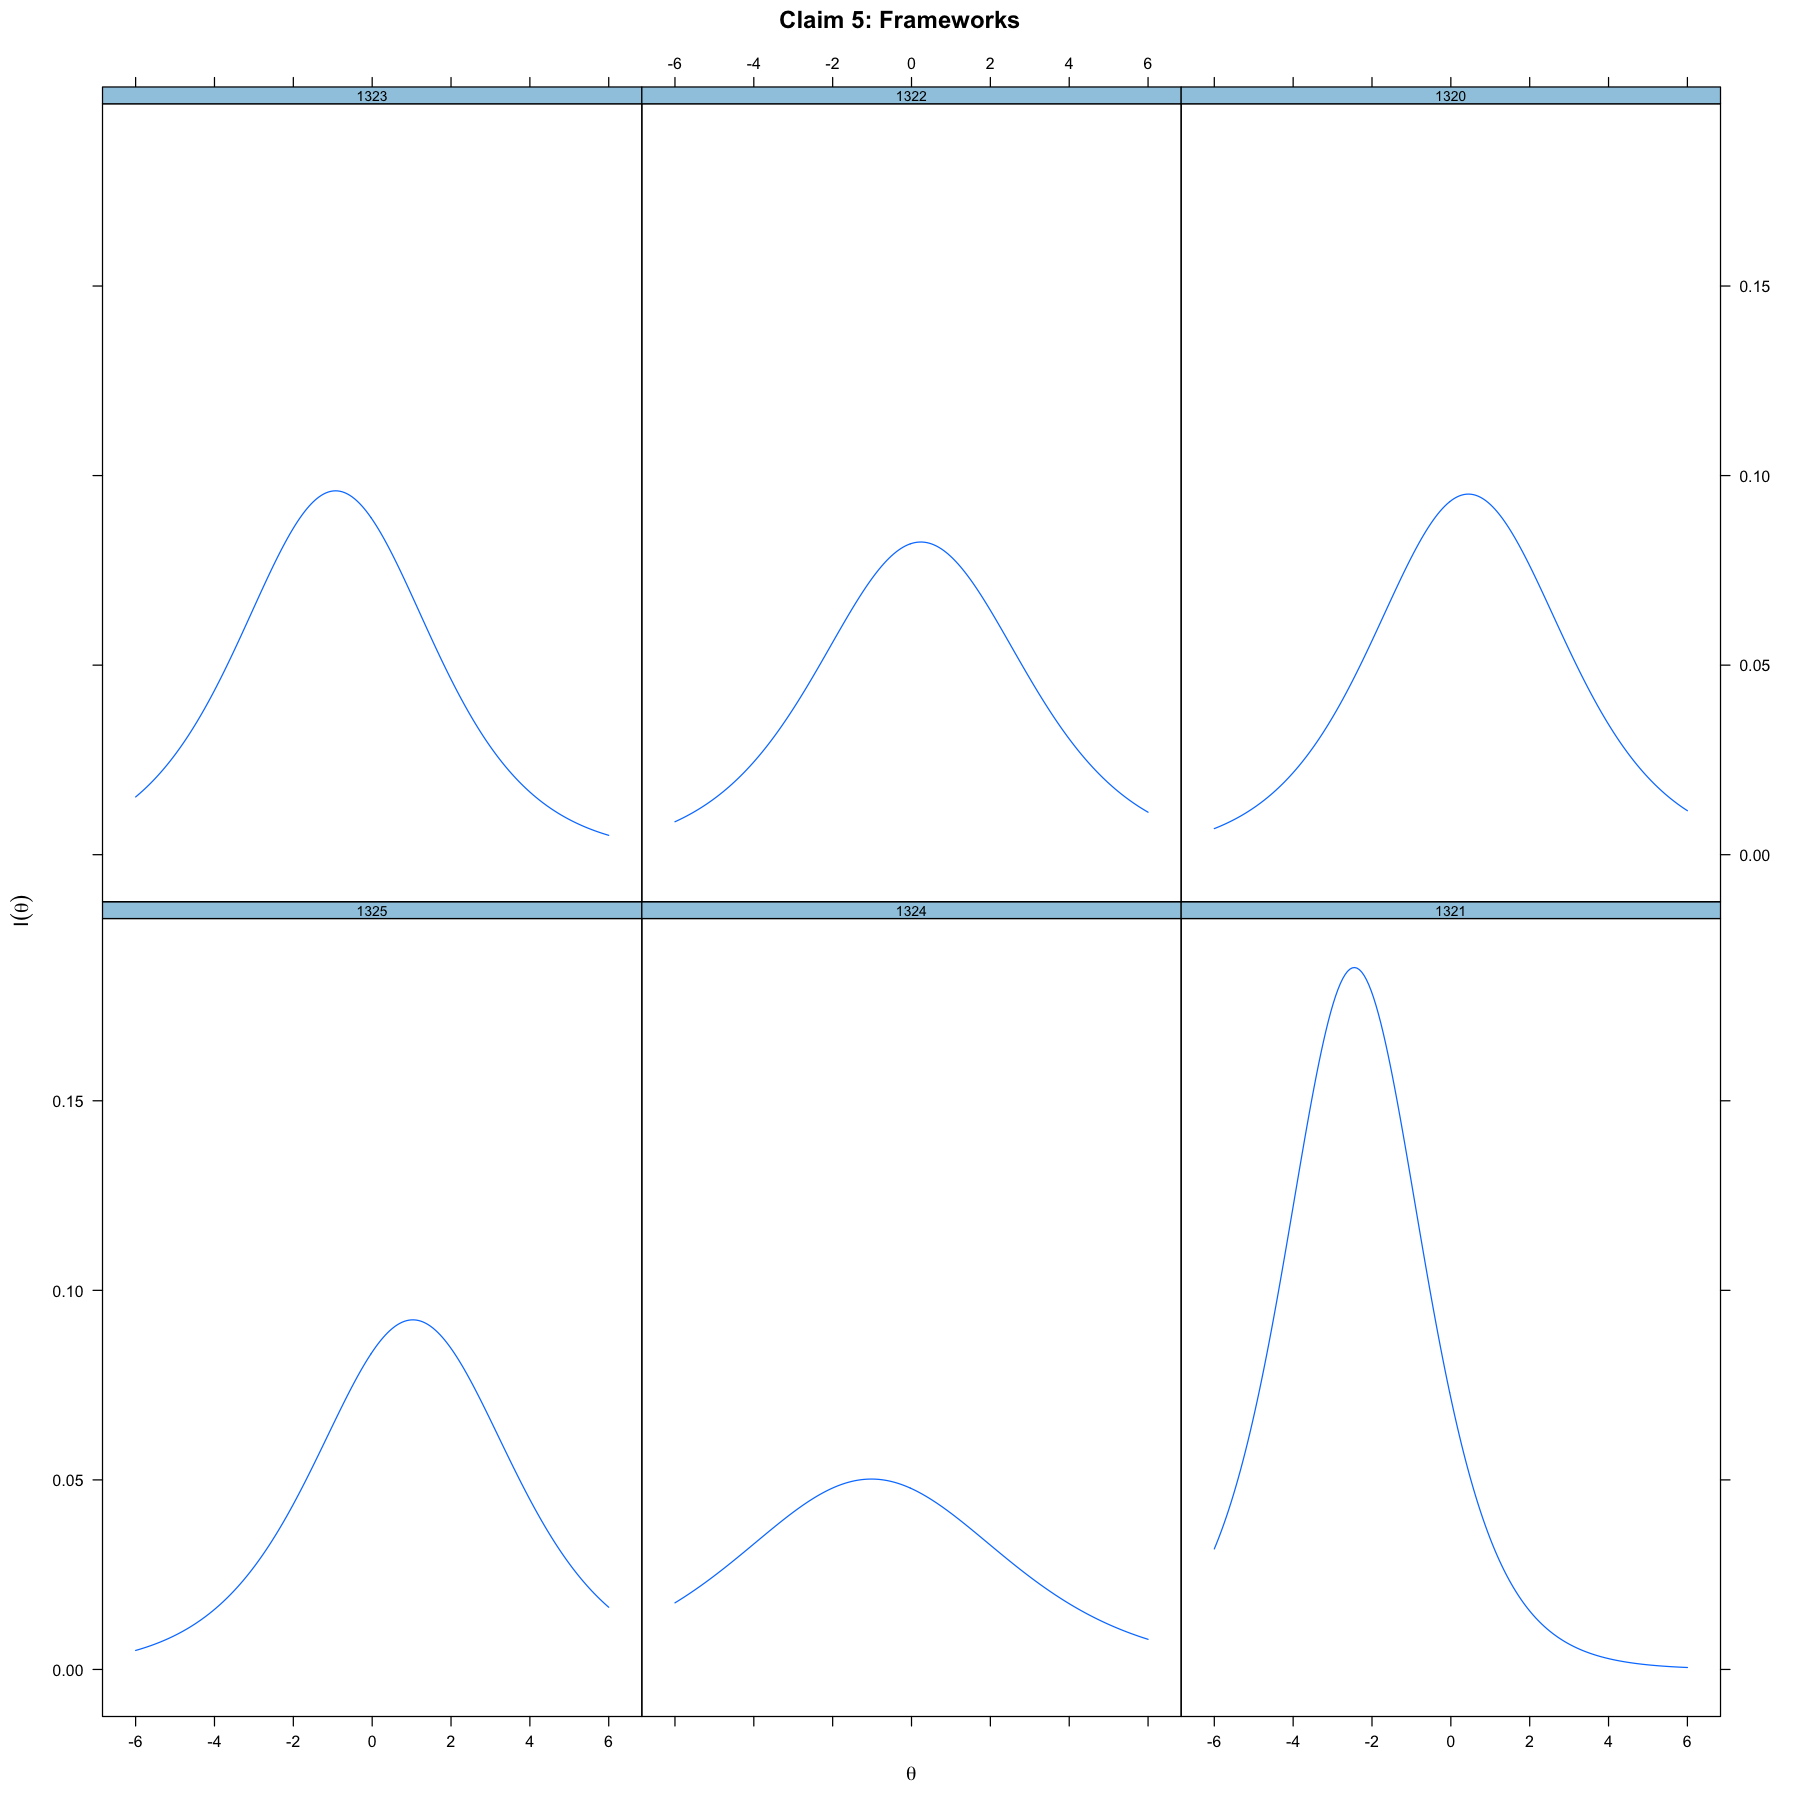

In [93]:

#plot(mod1_unidim, type = "infotrace",facet_items = F)

plot(mod1_unidim, type = "infotrace", which.items = which(df_blueprint$claim == "Claim 1"), facet_items = T, main = "Claim 1: Core Syntax")

plot(mod1_unidim, type = "infotrace", which.items = which(df_blueprint$claim == "Claim 2"), facet_items = T, main = "Claim 2: Container Objects")

plot(mod1_unidim, type = "infotrace", which.items = which(df_blueprint$claim == "Claim 3"), facet_items = T, main = "Claim 3: Dist. Features")

plot(mod1_unidim, type = "infotrace", which.items = which(df_blueprint$claim == "Claim 4"), facet_items = T, main = "Claim 4: Std. Libraries")

plot(mod1_unidim, type = "infotrace", which.items = which(df_blueprint$claim == "Claim 5"), facet_items = T, main = "Claim 5: Frameworks")

# plot(mod1_unidim, type = "infotrace", which.items = which(df_blueprint$claim == "Claim 6"), facet_items = T, main = "Claim 6: Coding Tasks")